<a href="https://colab.research.google.com/github/Ilvecho/Project_5/blob/main/Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from datetime import timedelta

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

!pip install pmdarima
import pmdarima as pm
from pmdarima import auto_arima

# Import and load data

In [2]:
files.upload()
pass

Saving 2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv to 2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv to 2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv to 2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv to 2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv to 2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv to 2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv to 2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv
Saving 2020Q1Q2Q

In [18]:
file_list = os.listdir('/content/')
data = {}

for filename in file_list:
  if filename.startswith('2020Q1'):
    # Extract the country from the file name
    country = filename.split(' - ')[1].strip()
    tmp_data = pd.read_csv(filename)[:-1]
    # Set the Date as proper dtype, and set it as index
    tmp_data['Date'] = pd.to_datetime(tmp_data['Date'])
    tmp_data.set_index('Date', inplace=True)
    # Parse the price and Change % columns
    tmp_data['Price'] = tmp_data['Price'].apply(lambda x: x.replace(',', ''))
    tmp_data['Price'] = pd.to_numeric(tmp_data['Price'])
    tmp_data['Change %'] = tmp_data['Change %'].apply(lambda x: float(x.strip('%'))).sort_index()
    # Drop the other columns which are not needed
    tmp_data = tmp_data.drop(columns=['Open', 'High', 'Low', 'Vol.'], axis=1)
    # Set the frequency of the DataFrame to b = Business days
    tmp_data = tmp_data.asfreq('b')
    # By setting the frequency we create new rows which are empty (business days in which the stock market was closed, e.g. Public Holidays)
    # We need to fill the missing values, and we opt for a forward fill, i.e. we use the value of the previous day
    tmp_data = tmp_data.fillna(method='ffill')
    # Stored the processed data in the Dict
    data[country] = tmp_data

In [19]:
for key in data.keys():
  print('\n\n###########\n')
  print(key)
  print(data[key].info())



###########

Egypt
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 2020-01-02 to 2021-03-31
Freq: B
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     325 non-null    float64
 1   Change %  325 non-null    float64
dtypes: float64(2)
memory usage: 7.6 KB
None


###########

Turkey
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 2020-01-02 to 2021-03-31
Freq: B
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     325 non-null    float64
 1   Change %  325 non-null    float64
dtypes: float64(2)
memory usage: 7.6 KB
None


###########

Colombia
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 2020-01-02 to 2021-03-31
Freq: B
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     325 non-null    float64
 1   Change %  325 no

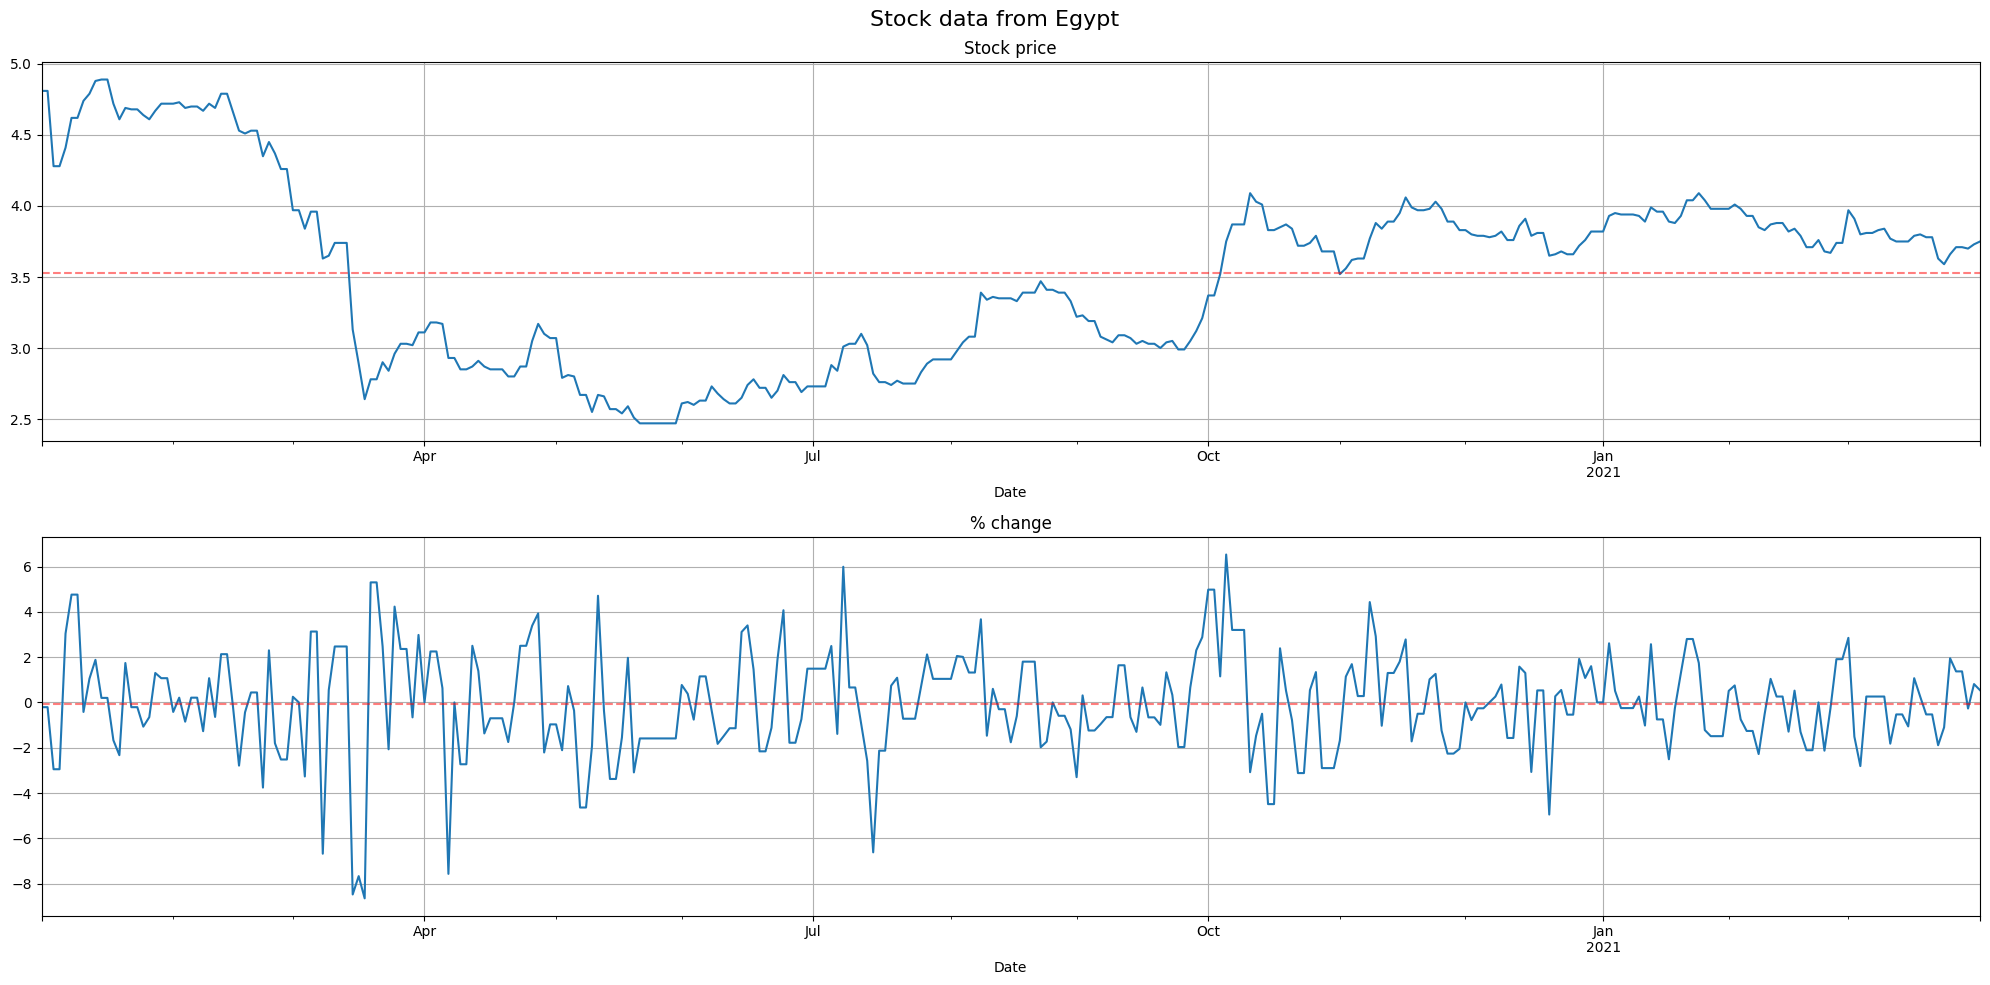

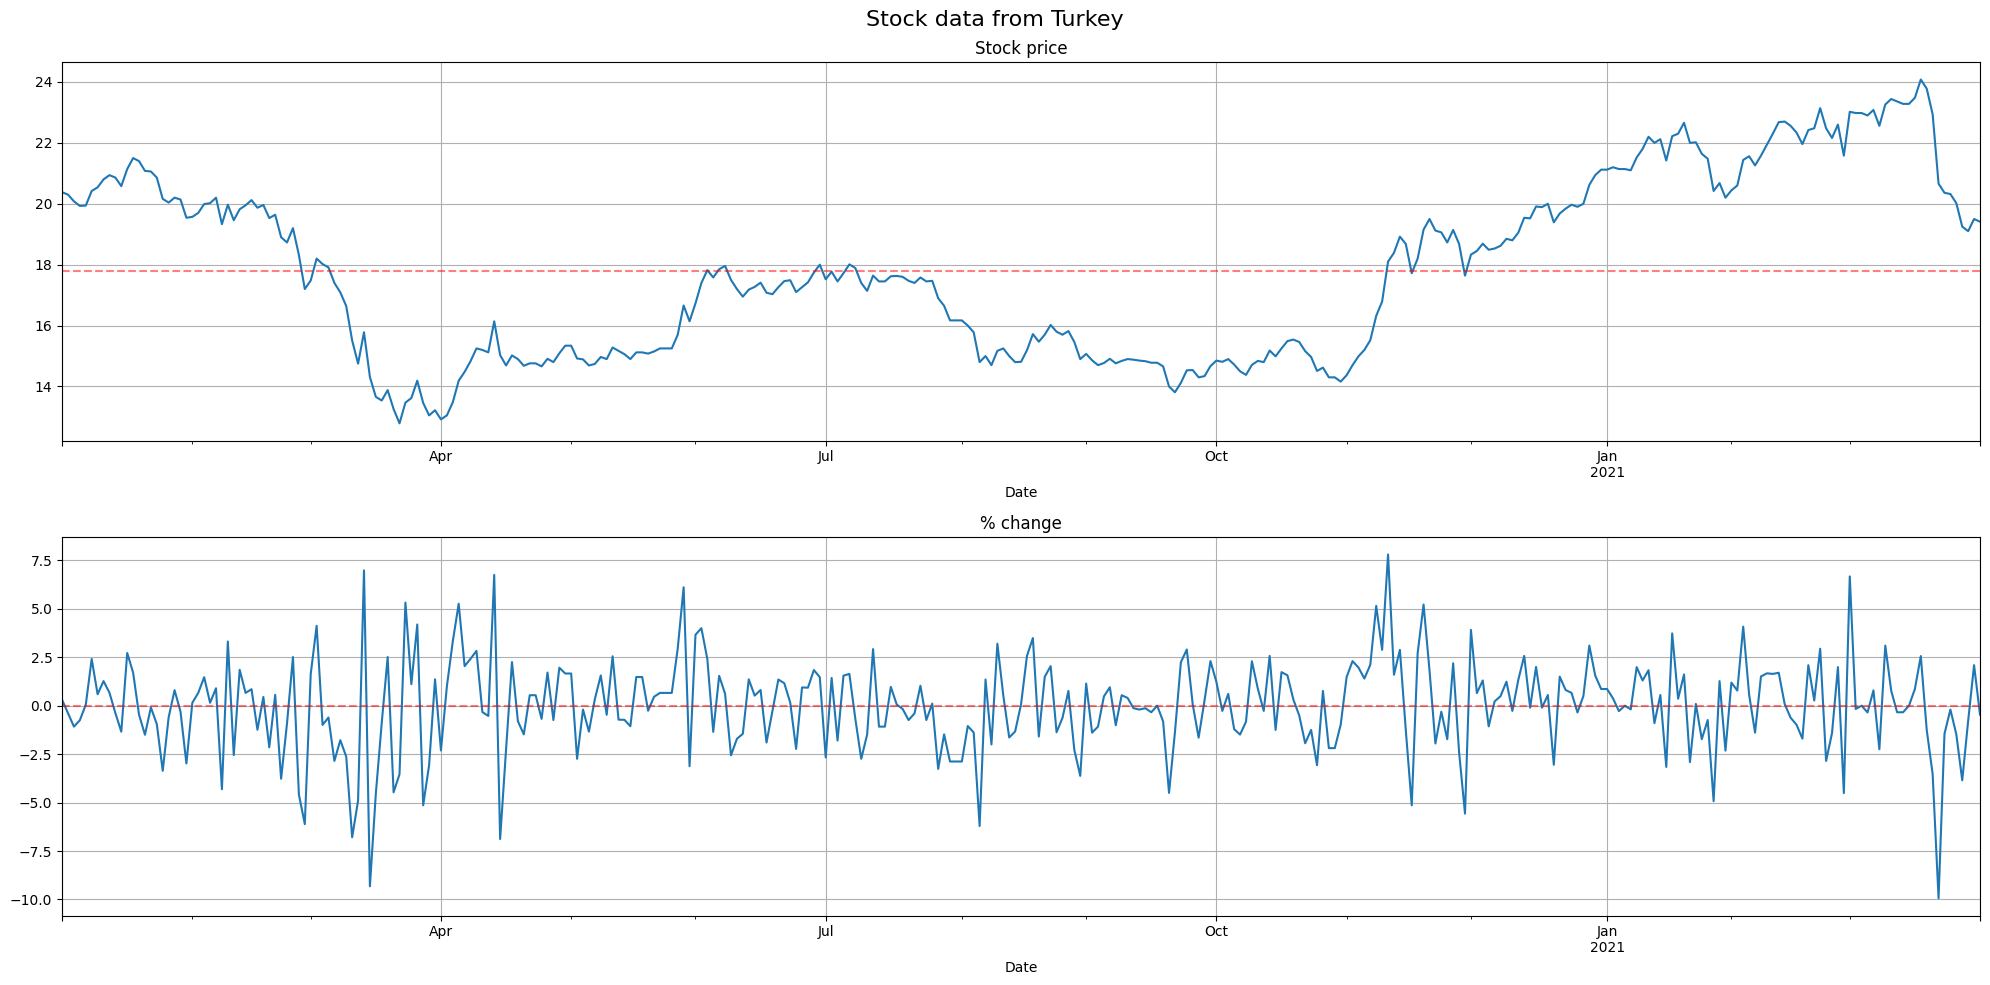

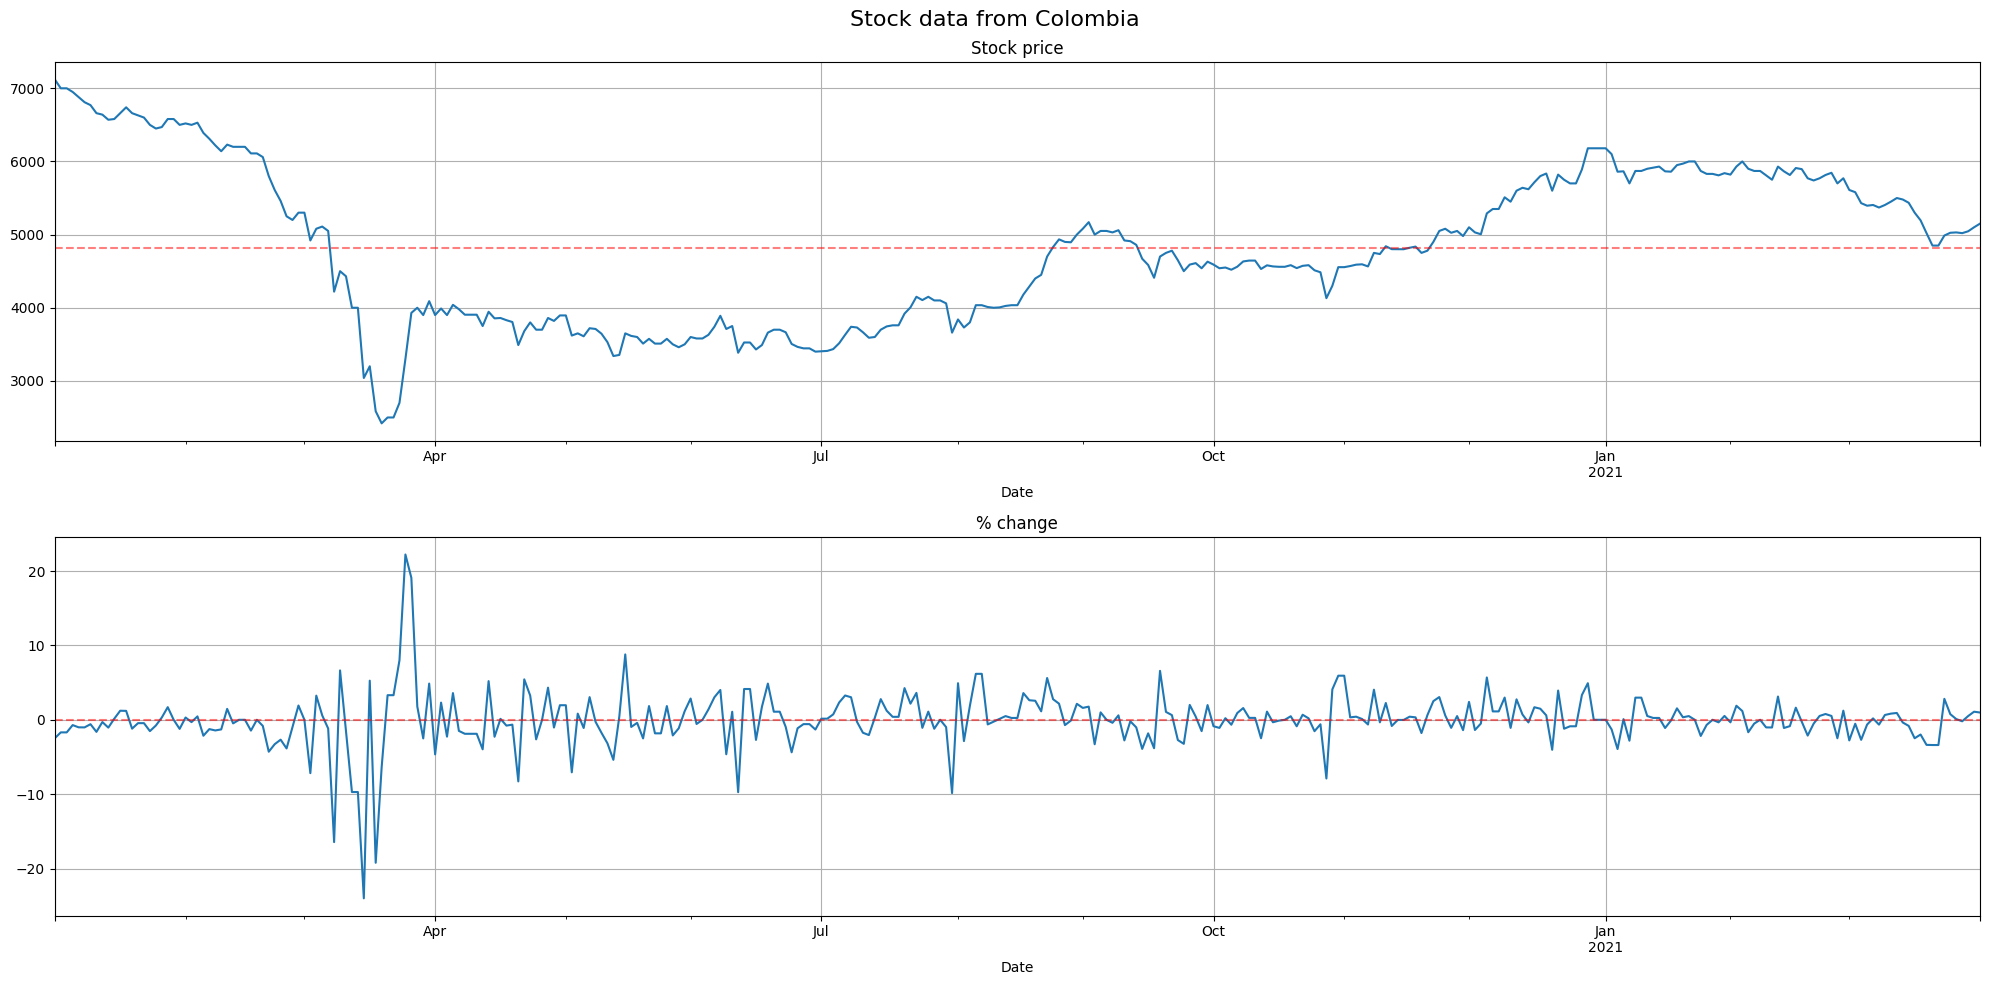

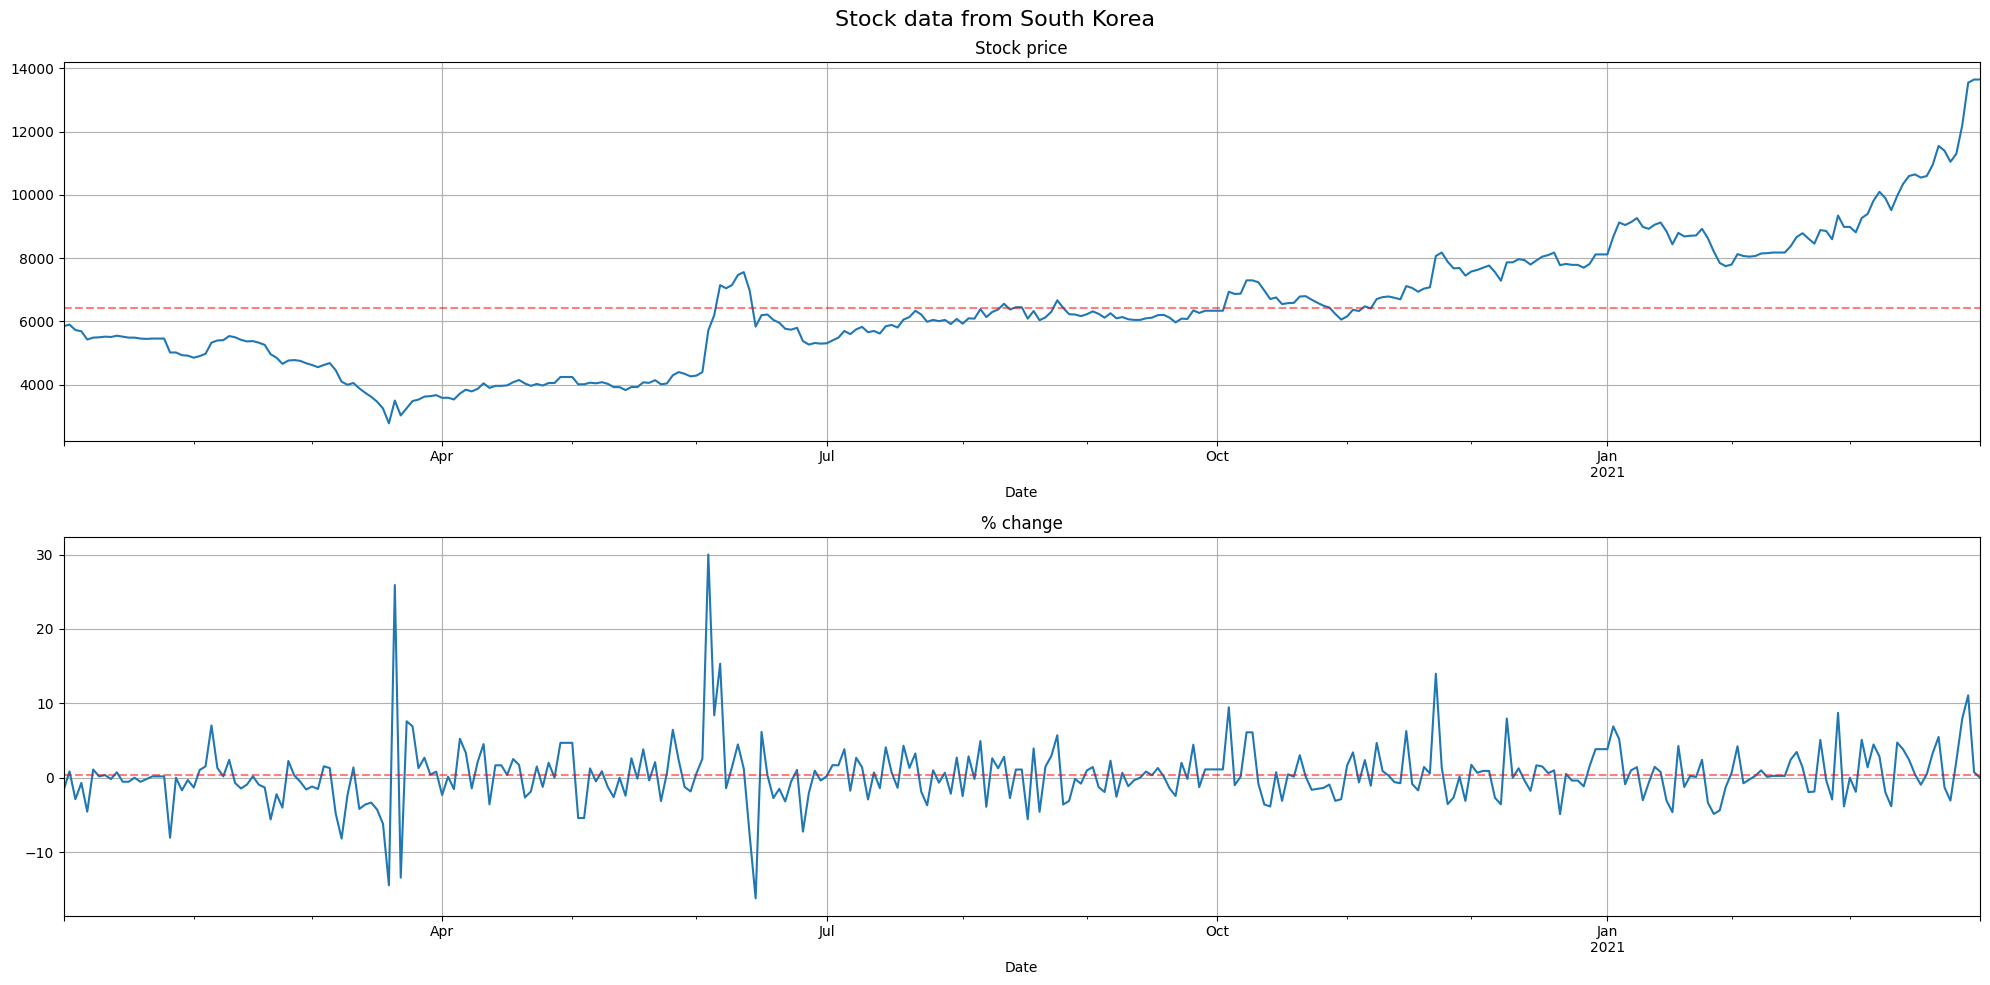

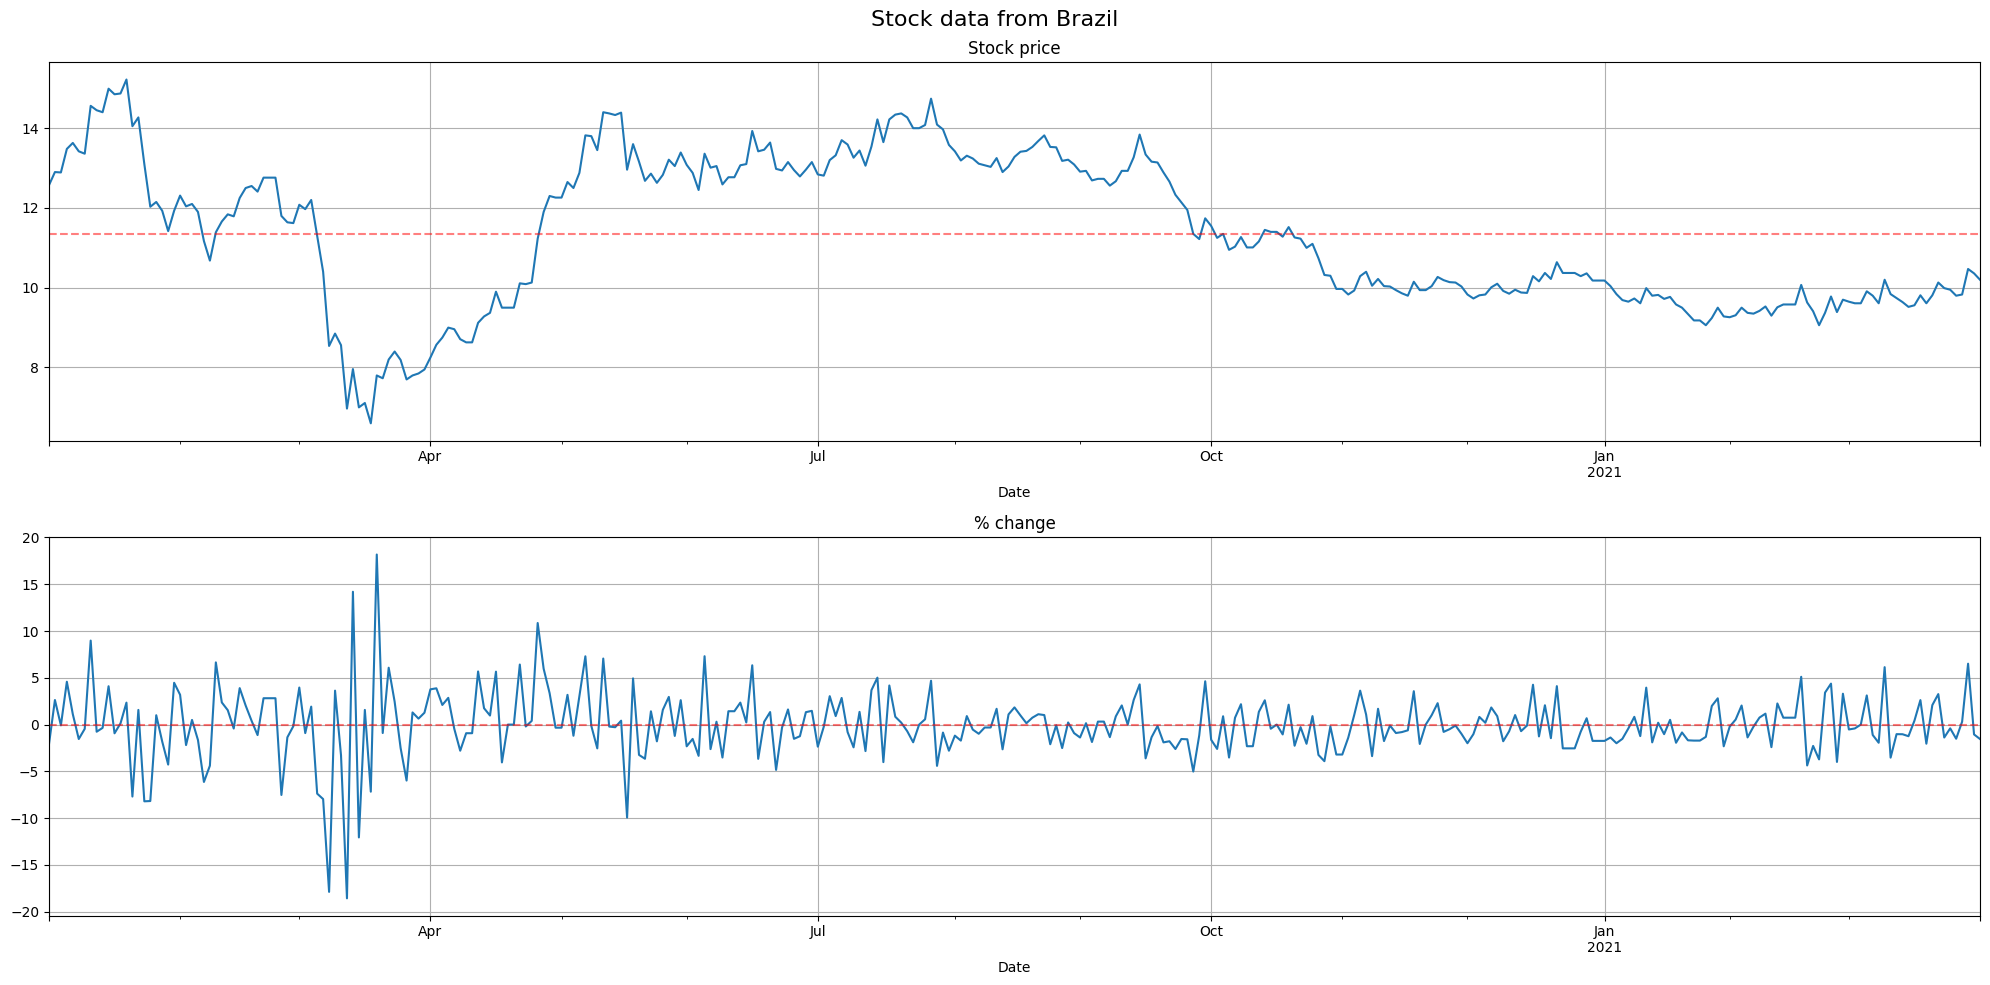

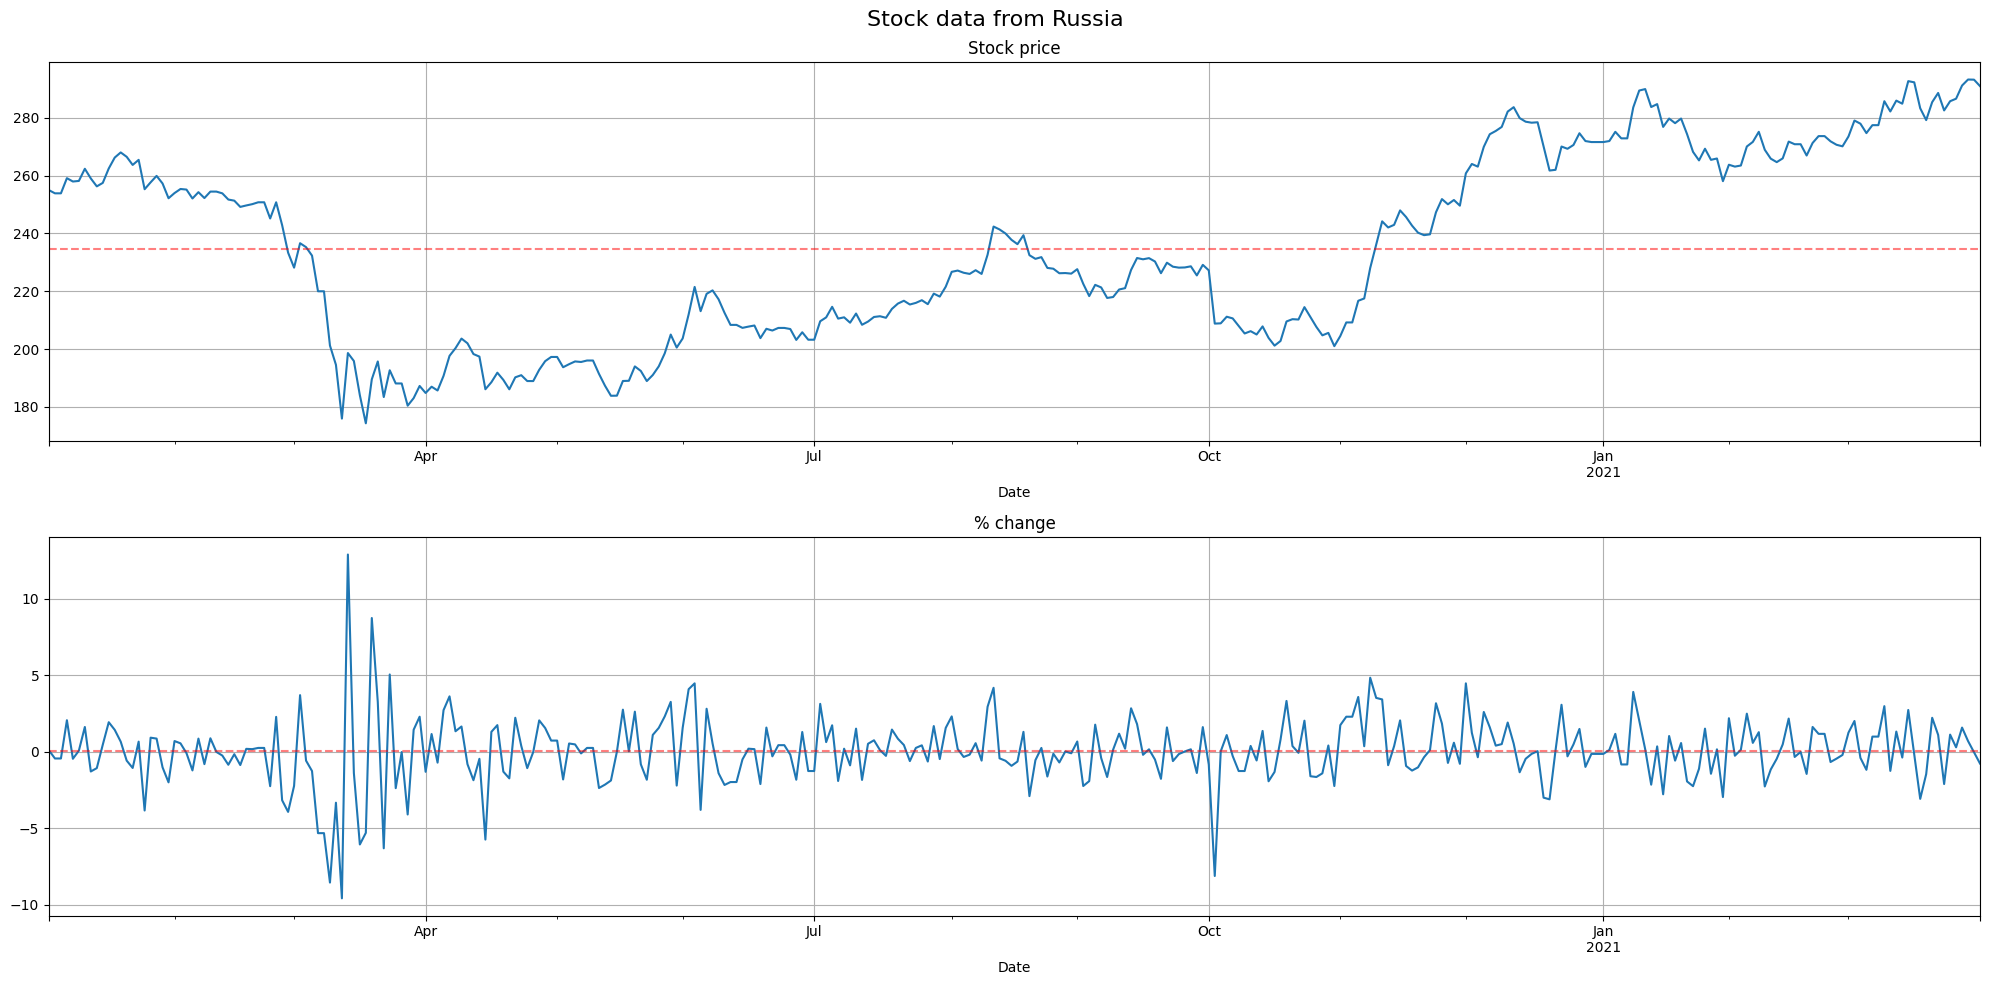

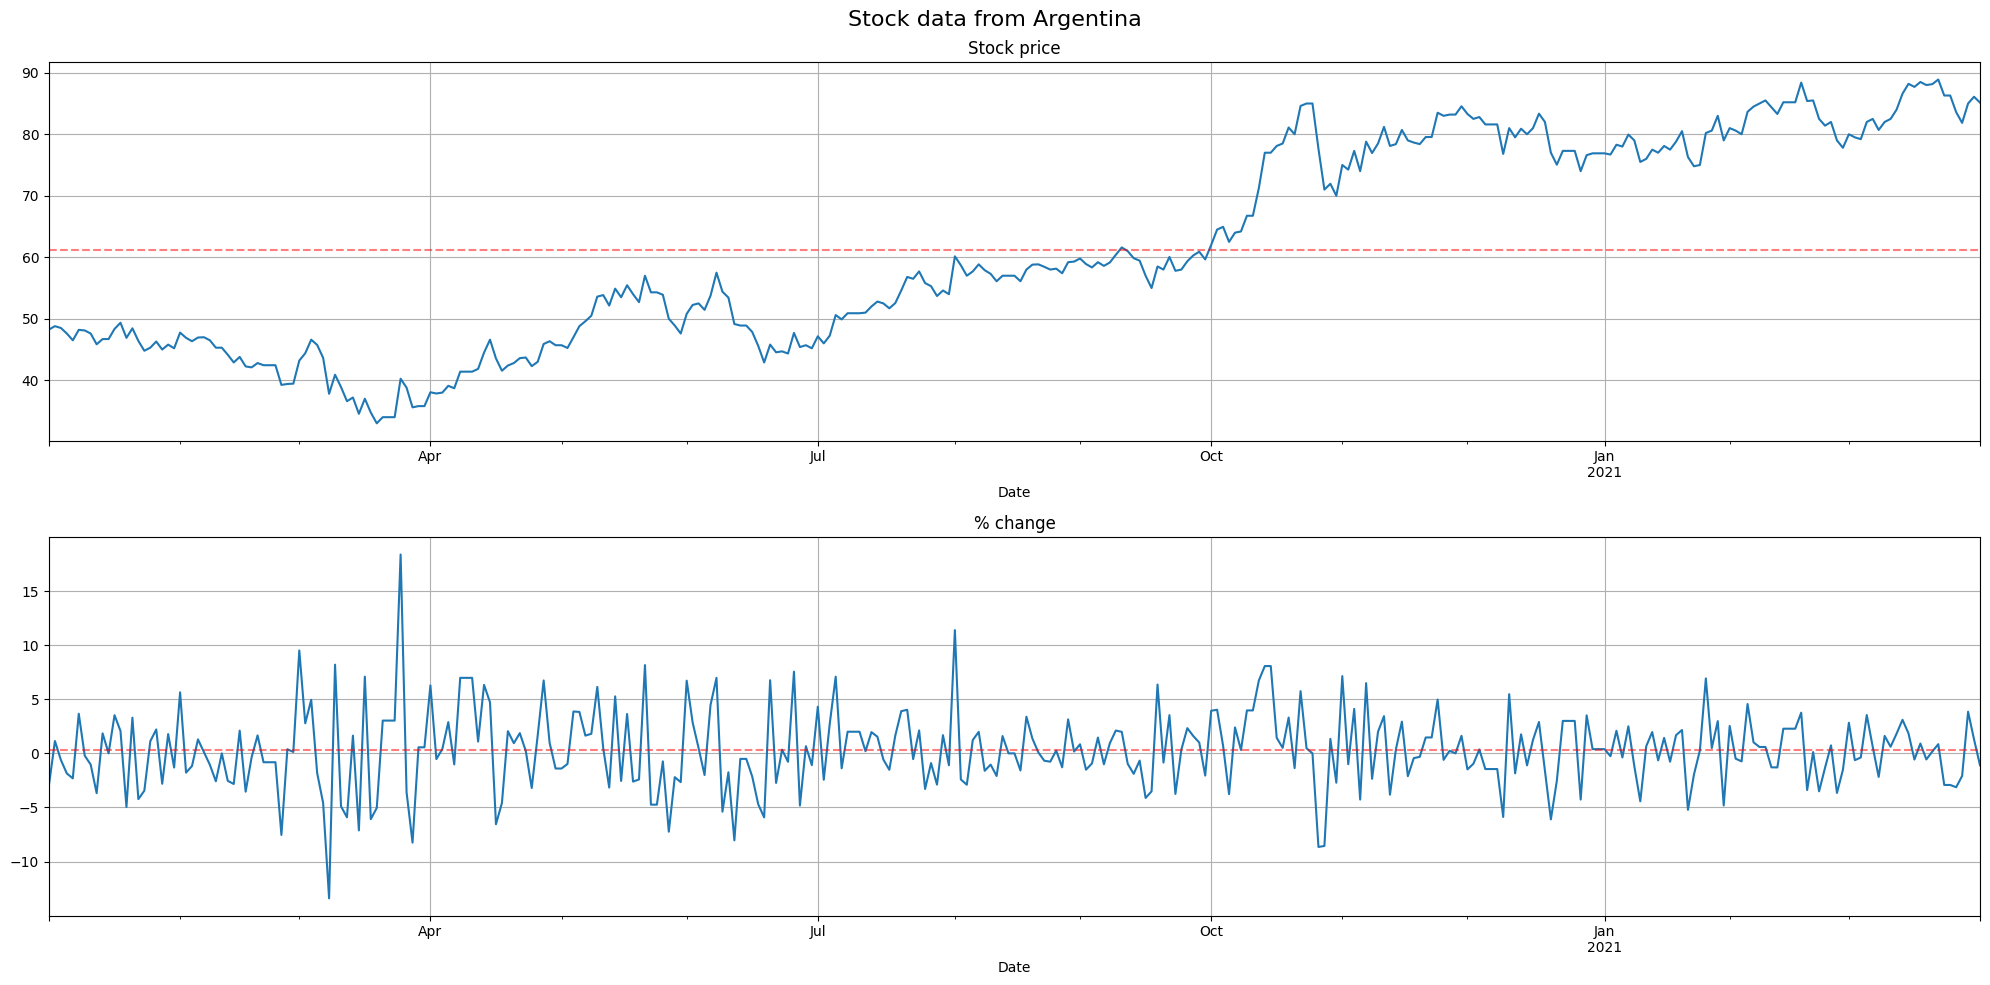

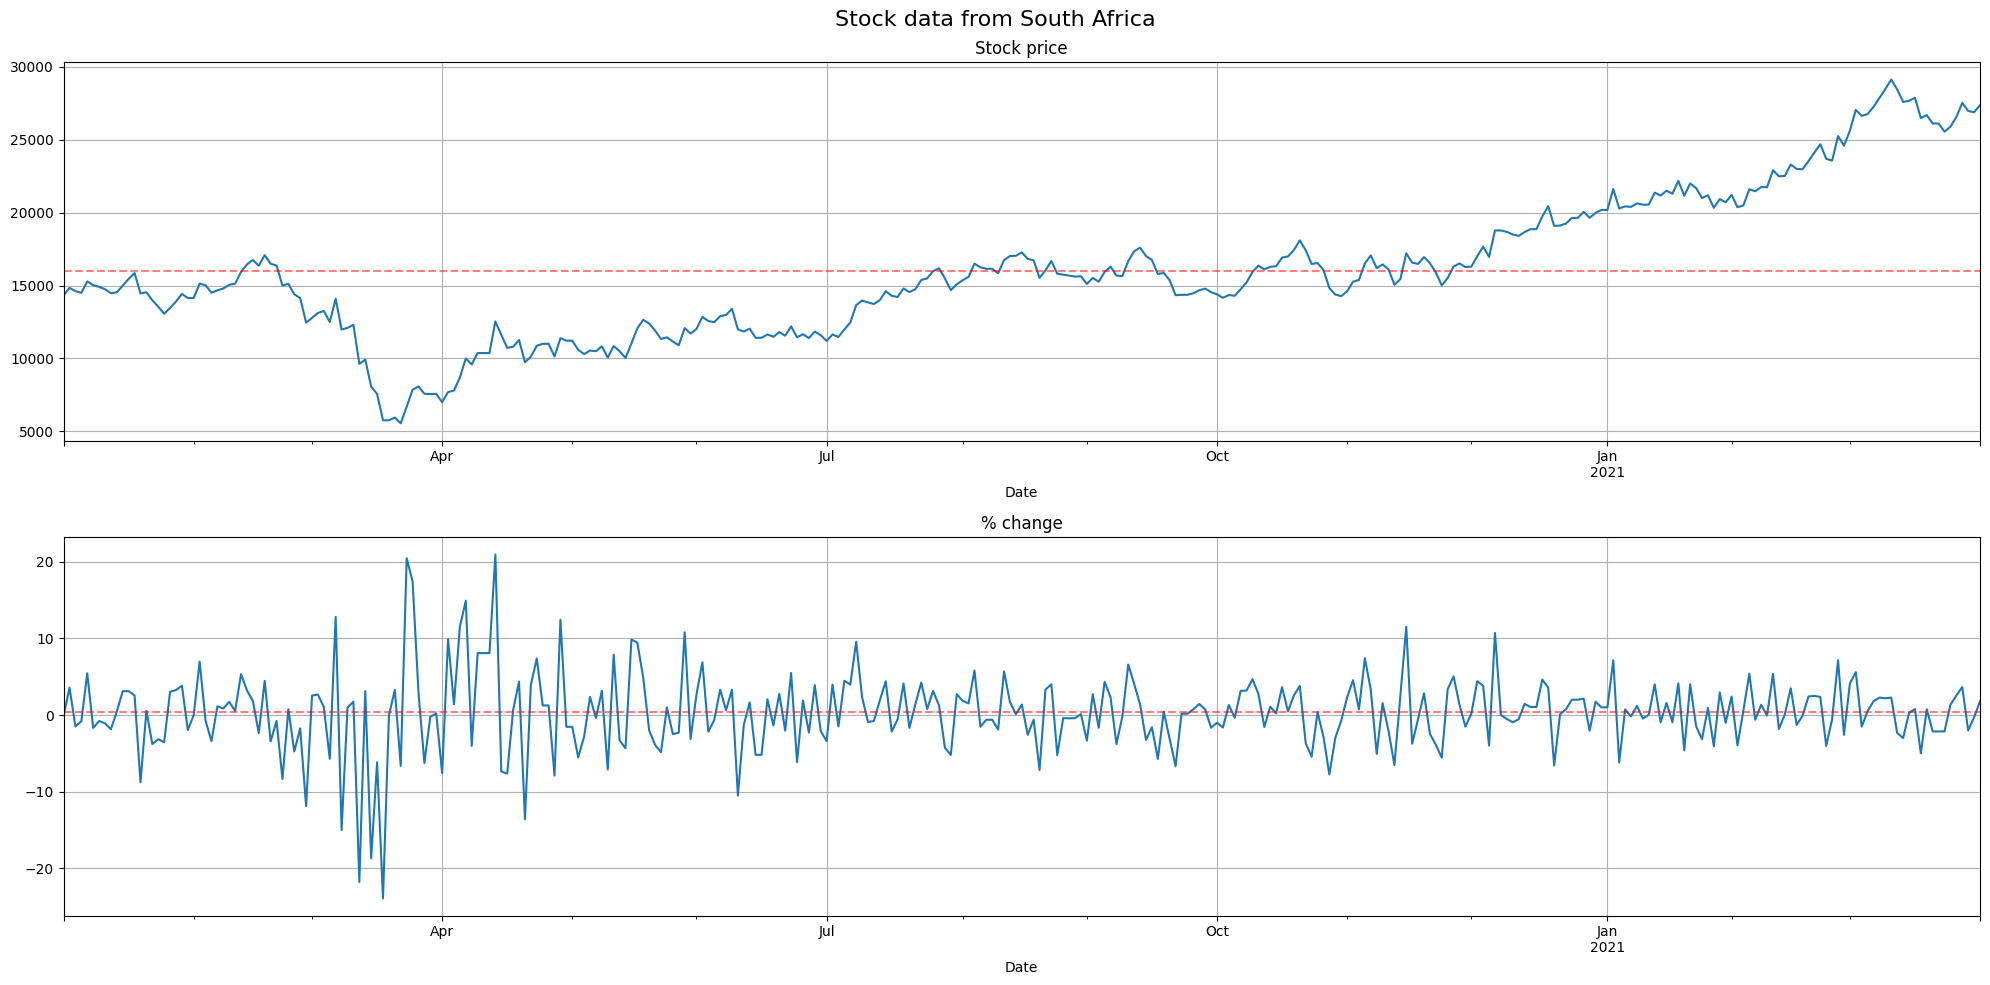

In [24]:
for key in data.keys():

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
  # Plot the price in subplot 1
  data[key]['Price'].plot(ax=axes[0], grid='on')
  axes[0].axhline(y=data[key]['Price'].mean(), color='red',  alpha=0.5, linestyle='--')
  axes[0].set_title('Stock price')

  # Plot the Change % in subplot 2
  data[key]['Change %'].plot(ax=axes[1], grid='on')
  axes[1].axhline(y=data[key]['Change %'].mean(), color='red',  alpha=0.5, linestyle='--')
  axes[1].set_title('% change')

  # set the figure title
  fig.suptitle(f'Stock data from {key}', fontsize=16)

  plt.tight_layout()
  plt.show()

We can clearly see that the Price time series are **not stationary** (we will robustly test this statement, but also the visual inspection is enough).

On the other hand, the **change %** looks stationary

# EDA - stationarity

We verify the stationarity of the time series using the **Augmented Dickey-Fuller** test

In [26]:
for key in data.keys():
  p_price = adfuller(data[key]['Price'])
  p_change = adfuller(data[key]['Change %'])

  print(f'##########\n{key.upper()}\n')
  print('The p-value of the price is: ', p_price[1])
  print('The p-value of the change is: ', p_change[1])
  print('\n')

##########
EGYPT

The p-value of the price is:  0.24529851951451465
The p-value of the change is:  2.2460564051821874e-08


##########
TURKEY

The p-value of the price is:  0.5749764210297075
The p-value of the change is:  3.965023755190487e-10


##########
COLOMBIA

The p-value of the price is:  0.1879471059211641
The p-value of the change is:  1.2525817038593144e-12


##########
SOUTH KOREA

The p-value of the price is:  0.9973977003970093
The p-value of the change is:  1.778736997751879e-20


##########
BRAZIL

The p-value of the price is:  0.18411806668707226
The p-value of the change is:  1.2389232057027393e-11


##########
RUSSIA

The p-value of the price is:  0.7374602050812519
The p-value of the change is:  0.0001613258321228002


##########
ARGENTINA

The p-value of the price is:  0.8756756136964812
The p-value of the change is:  2.3476184551068446e-30


##########
SOUTH AFRICA

The p-value of the price is:  0.968855539556175
The p-value of the change is:  2.2714951607530134e-

We can see that the change % from all countries is **stationary**.

On the other hand, the Price is typically **non stationary**. The exceptions are Egypt, Colombia and Brazil, which show a stationary stock price as well

# EDA - autocorrelation

let's compute the autocorrelation of the change series

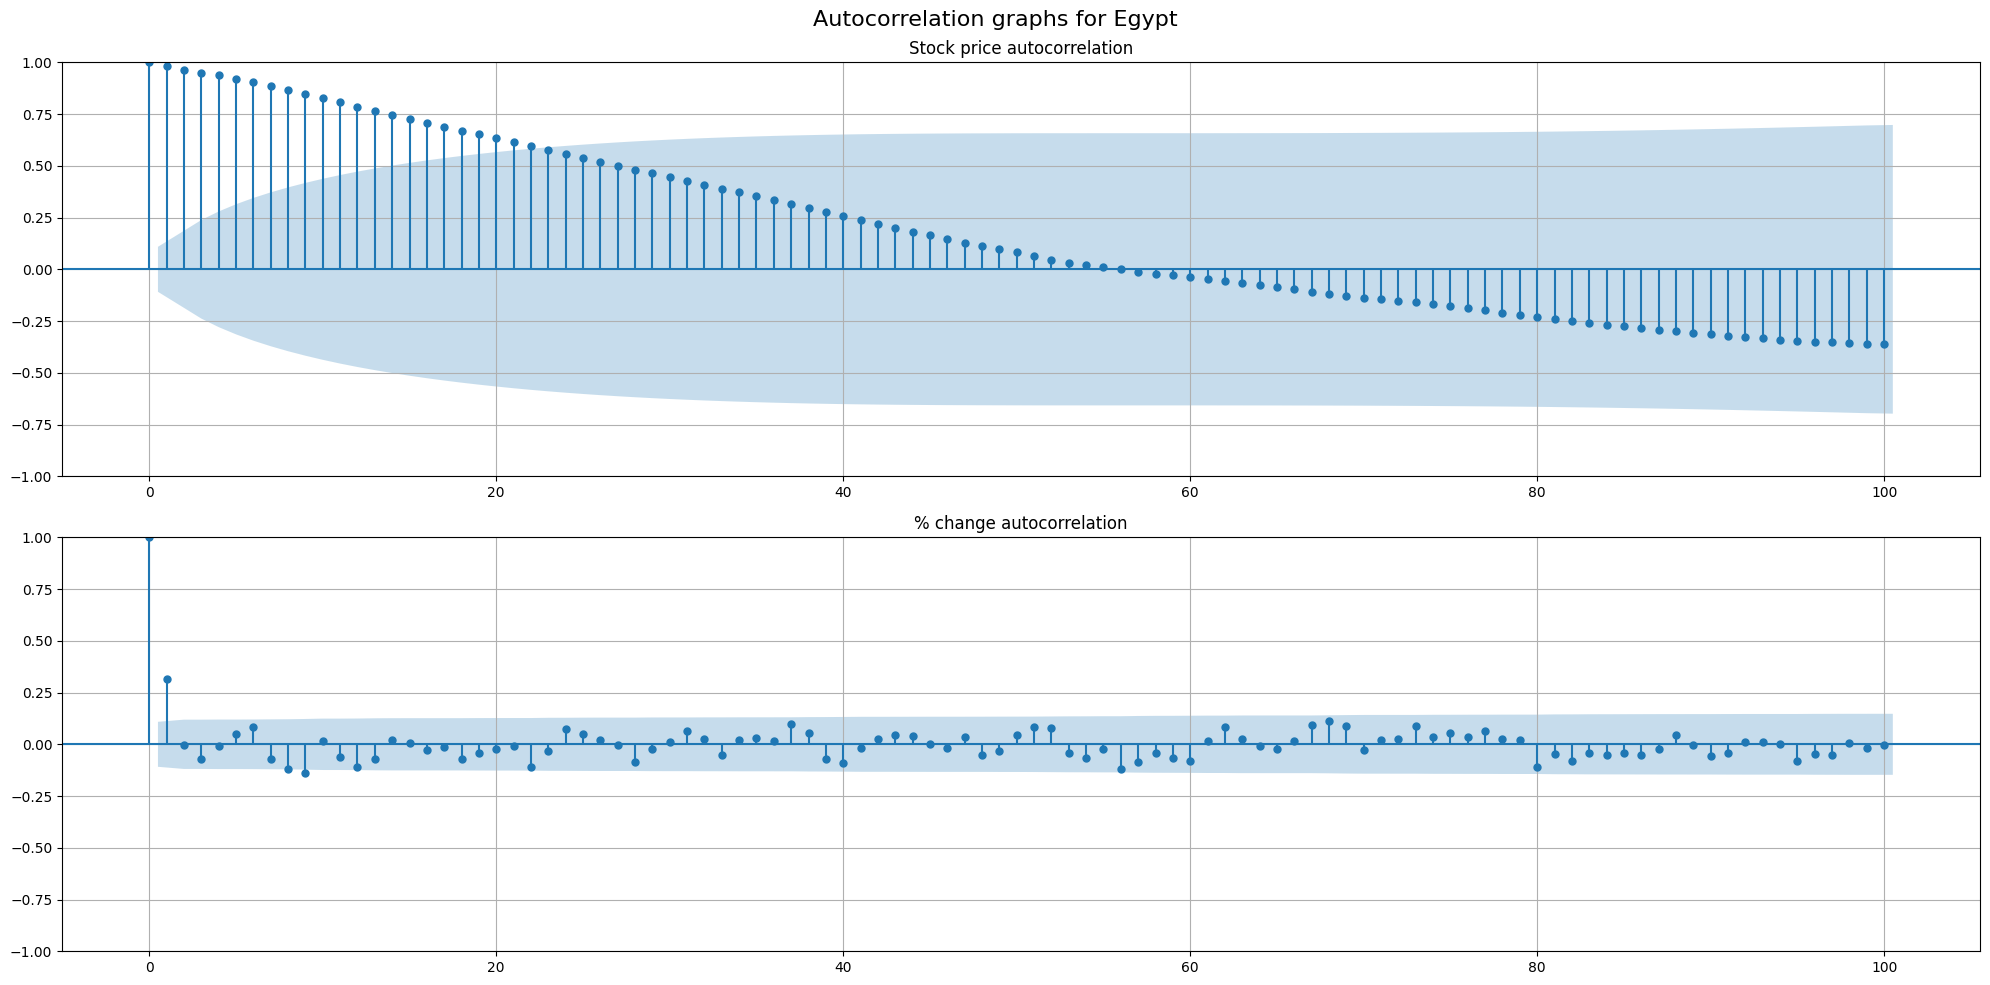

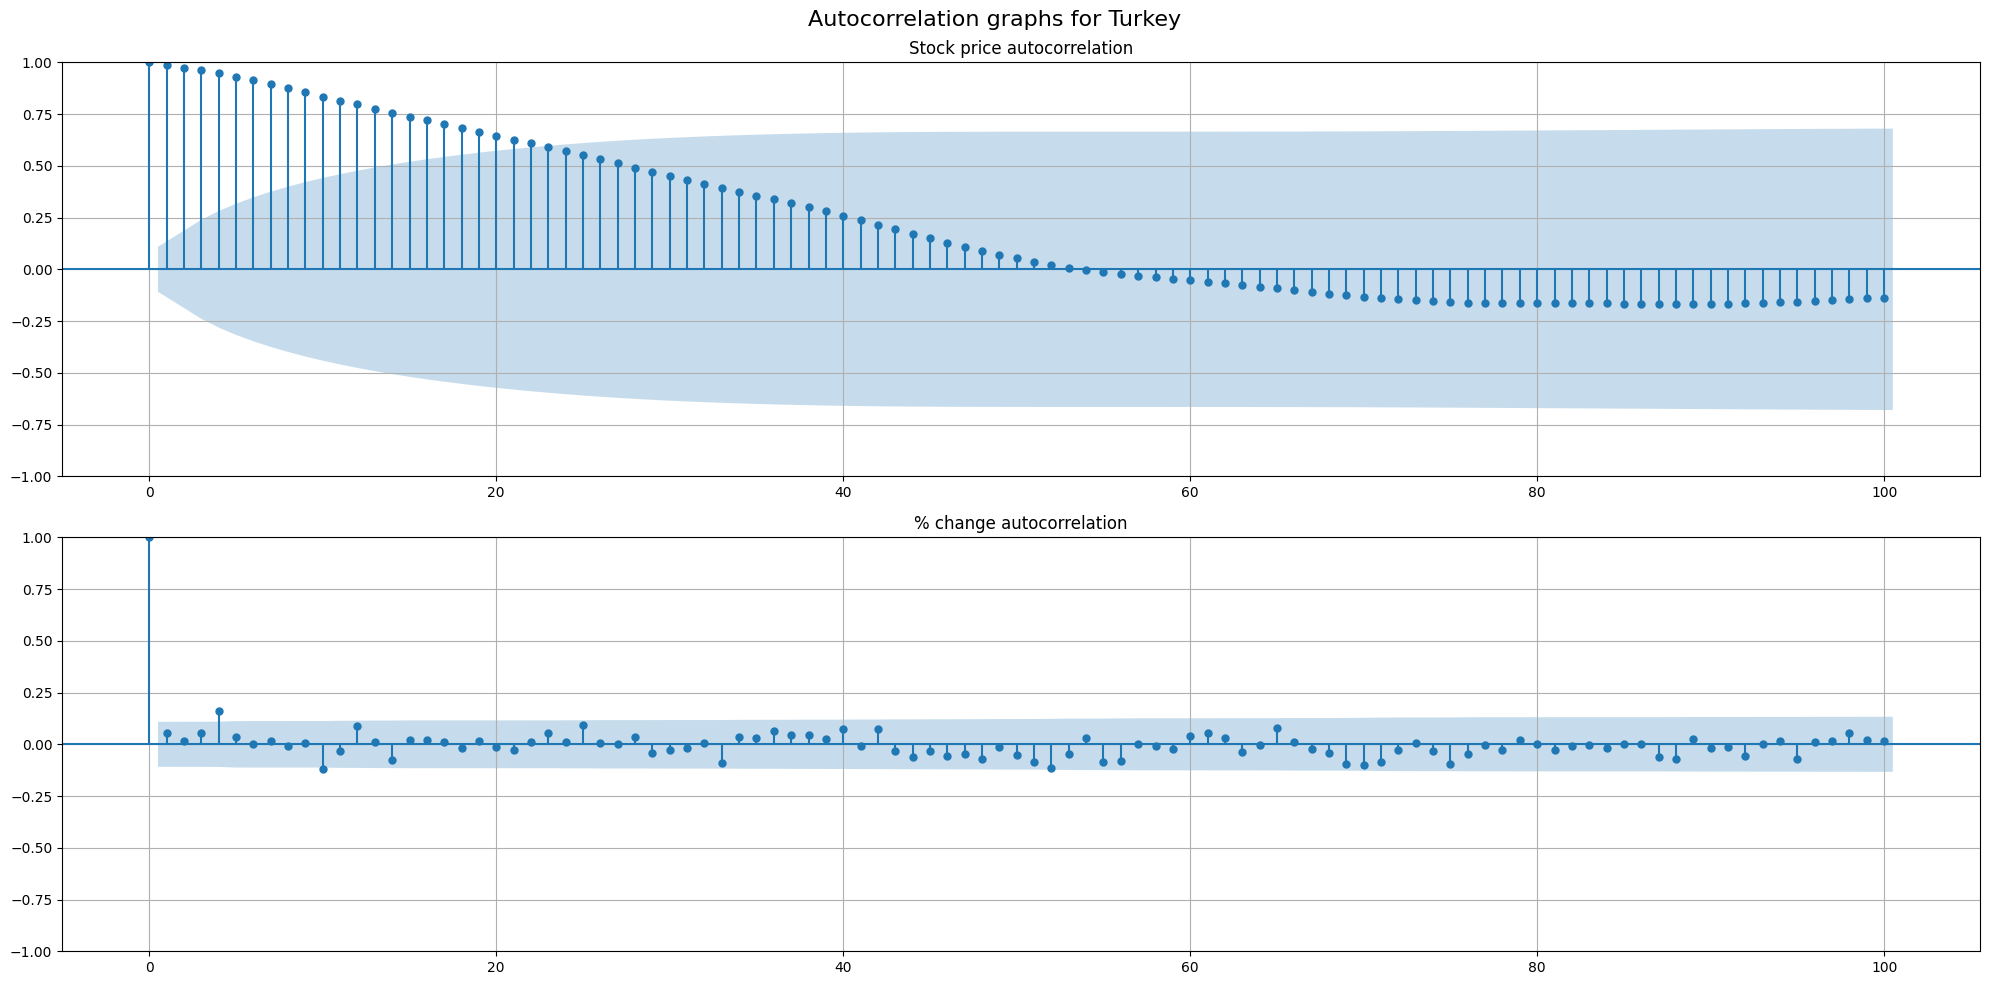

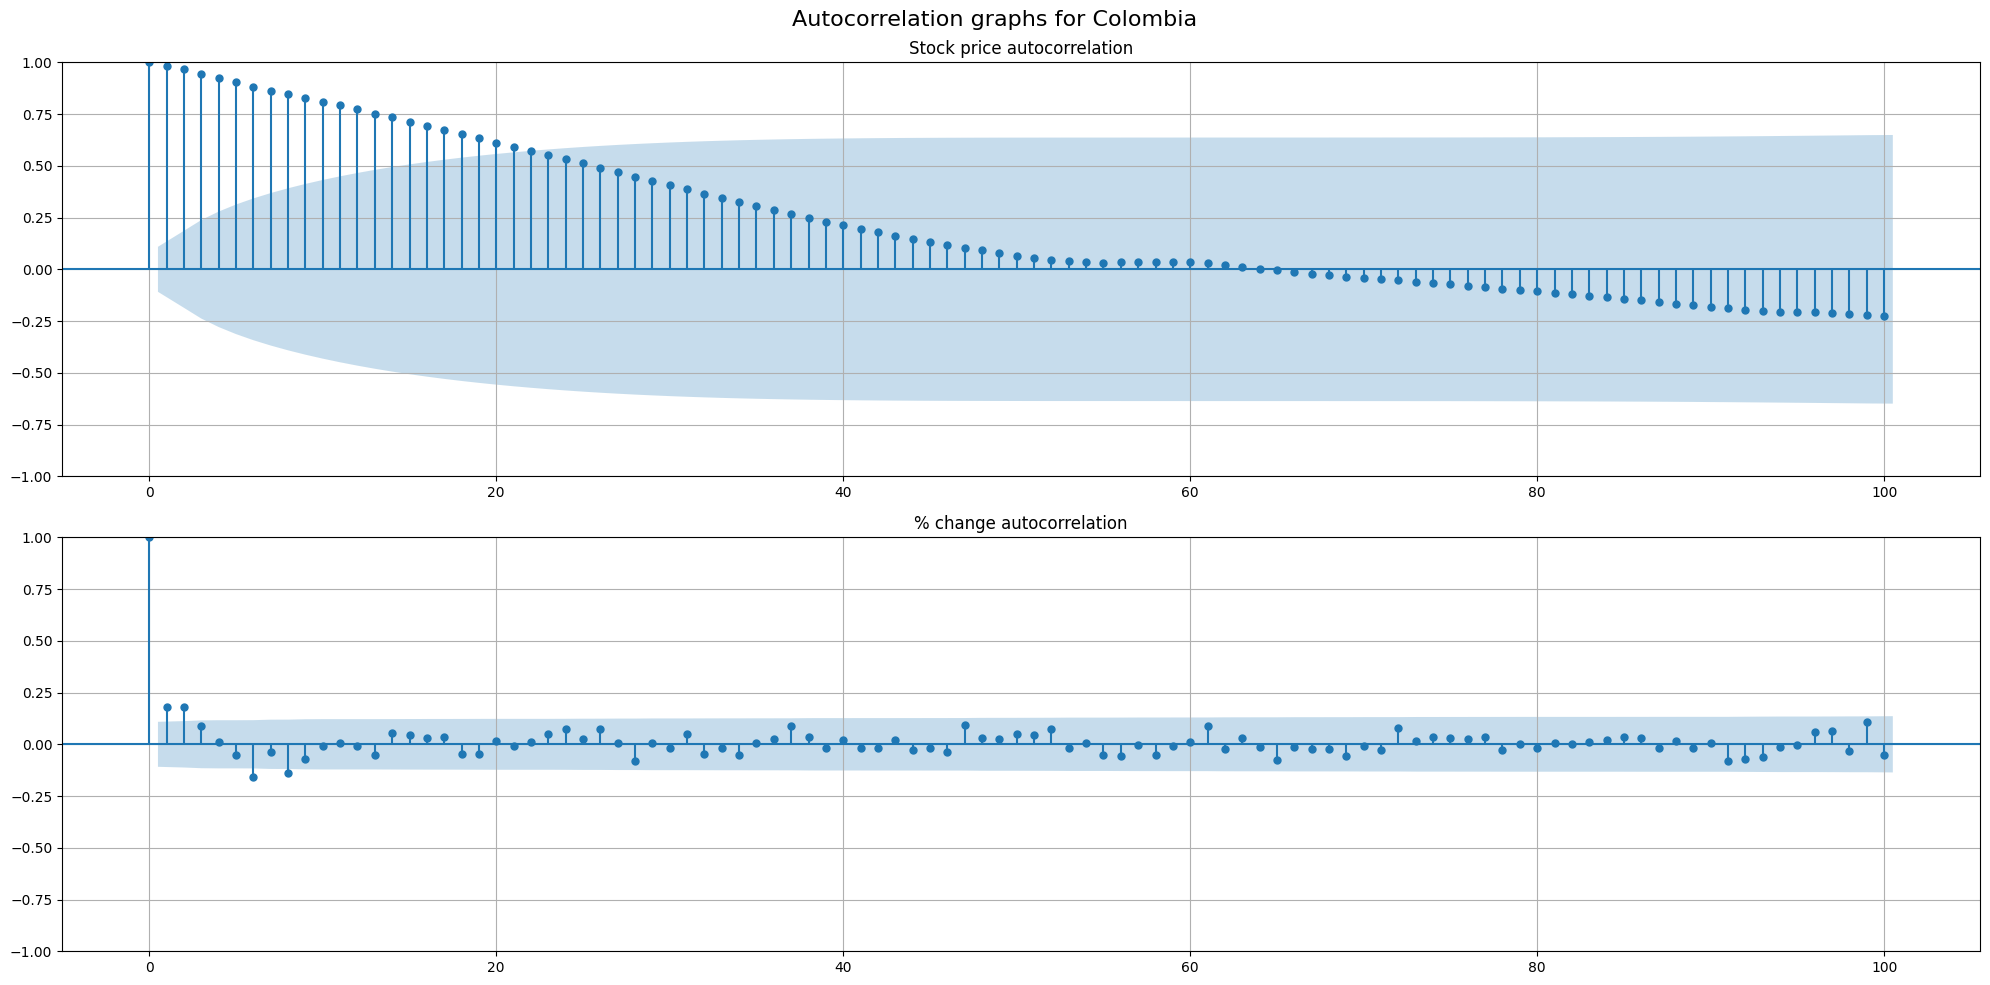

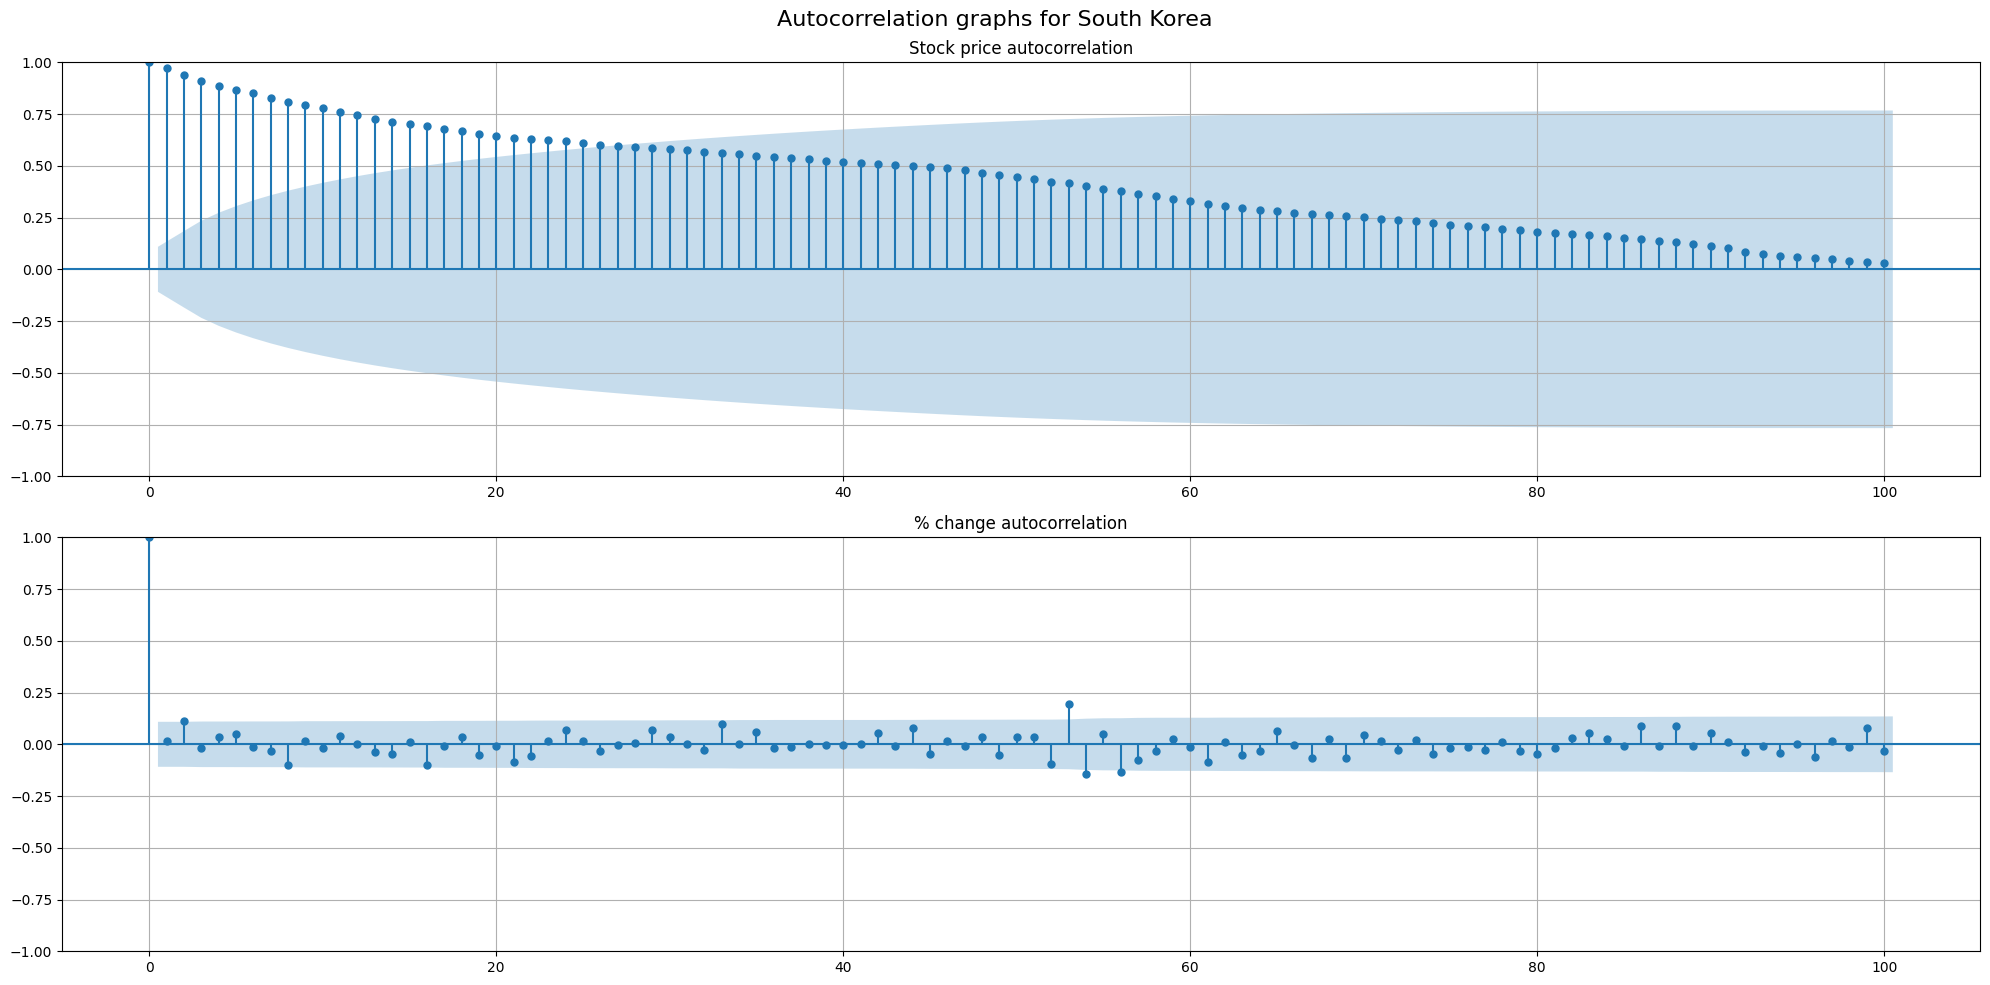

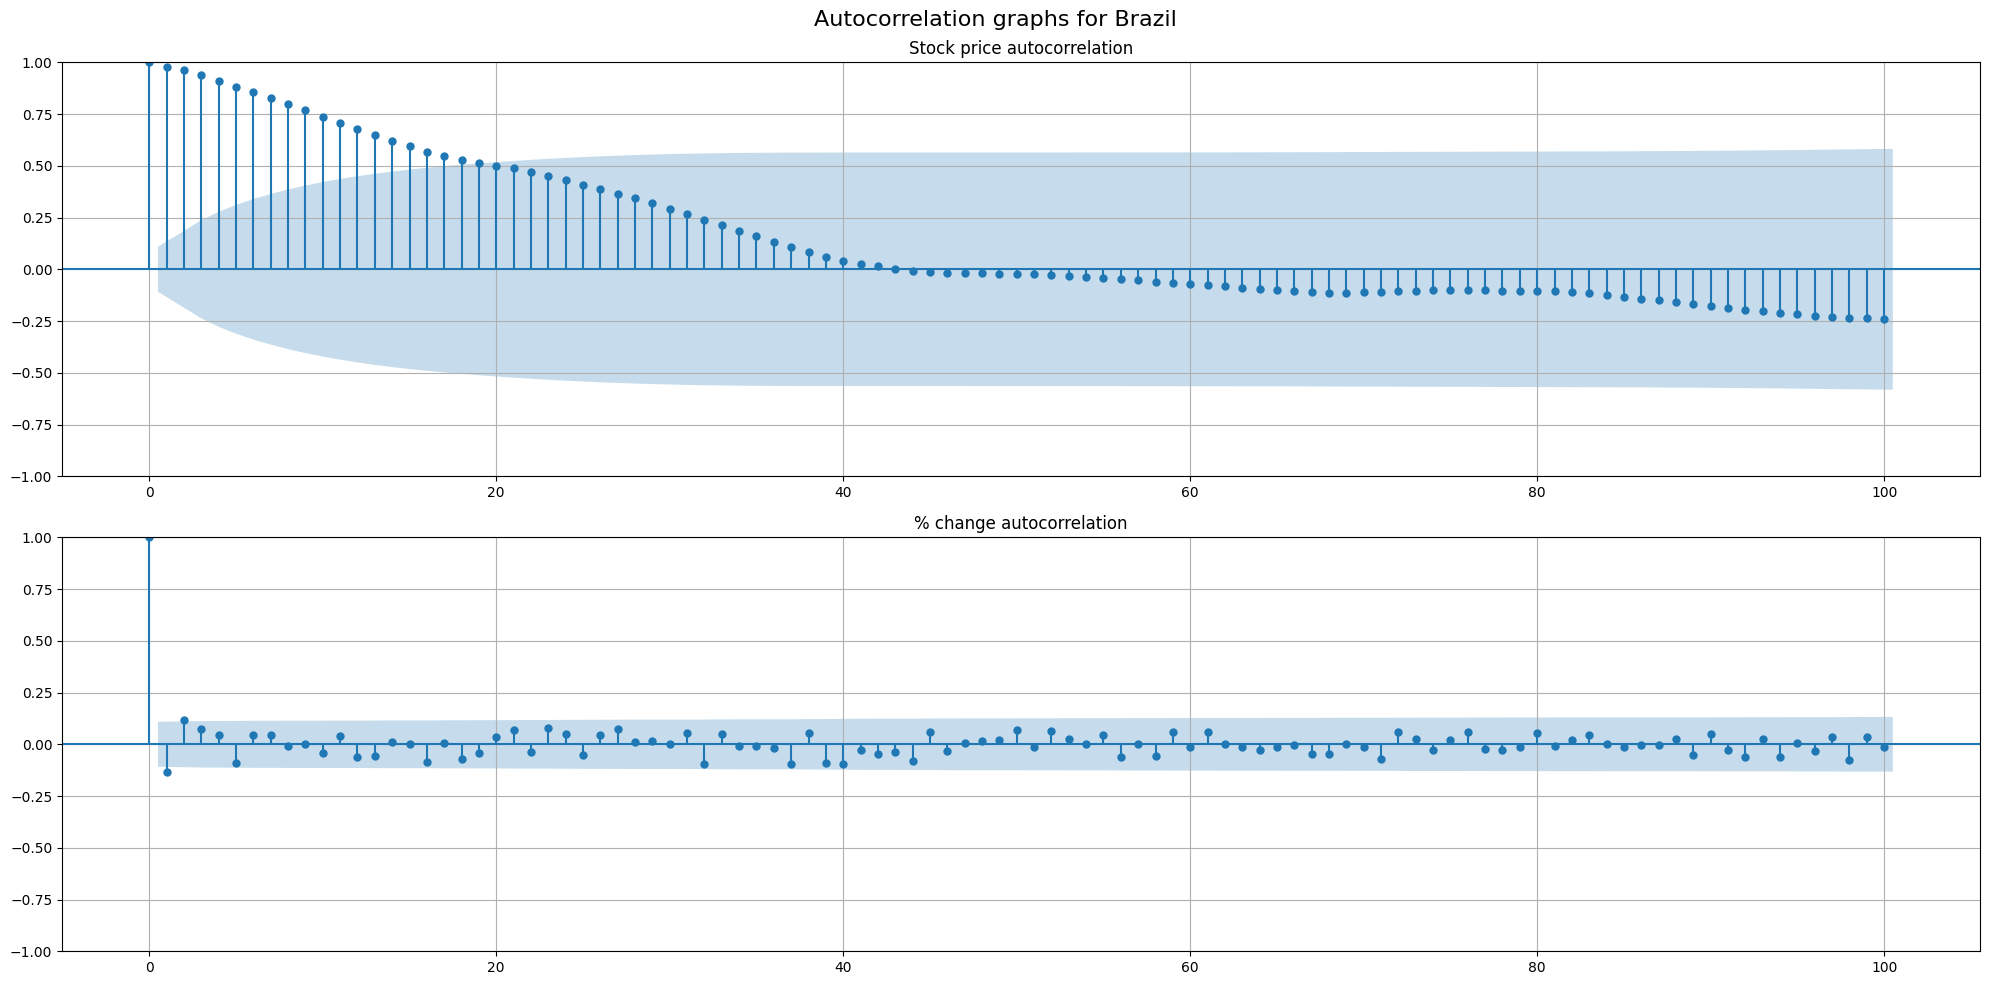

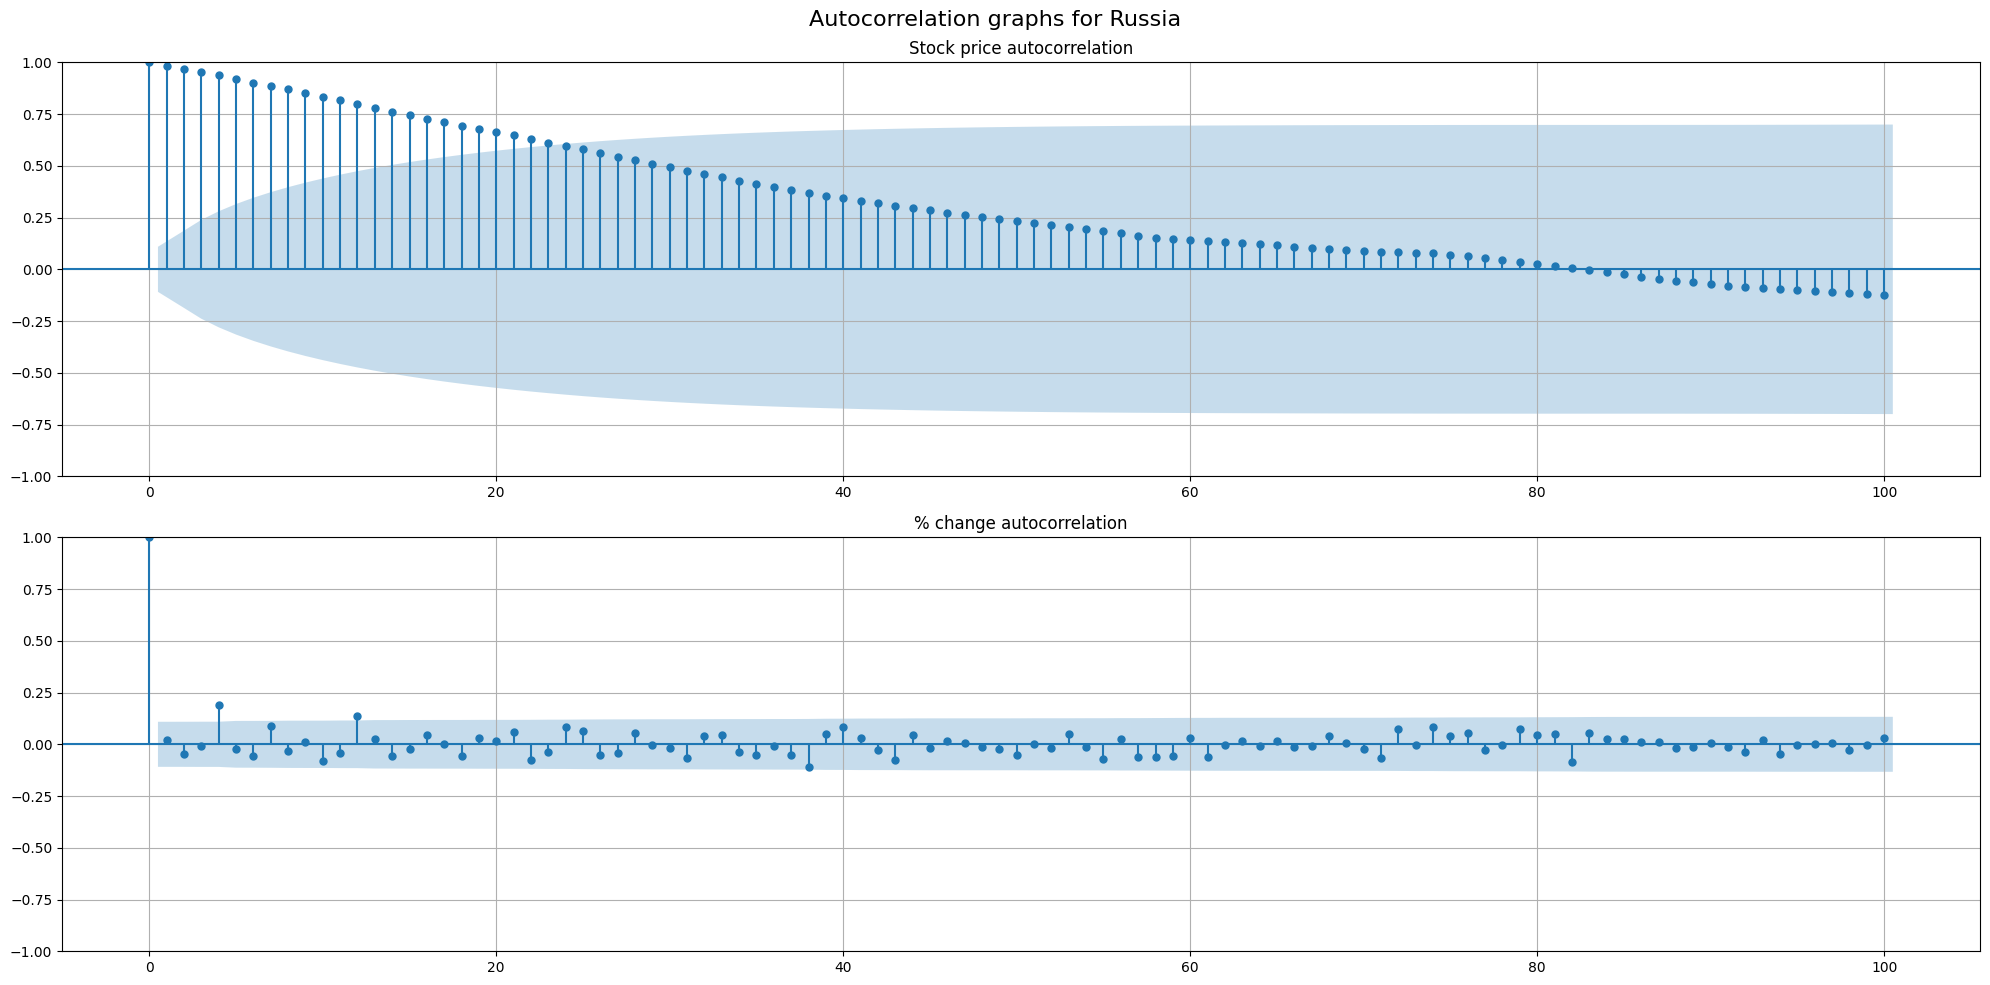

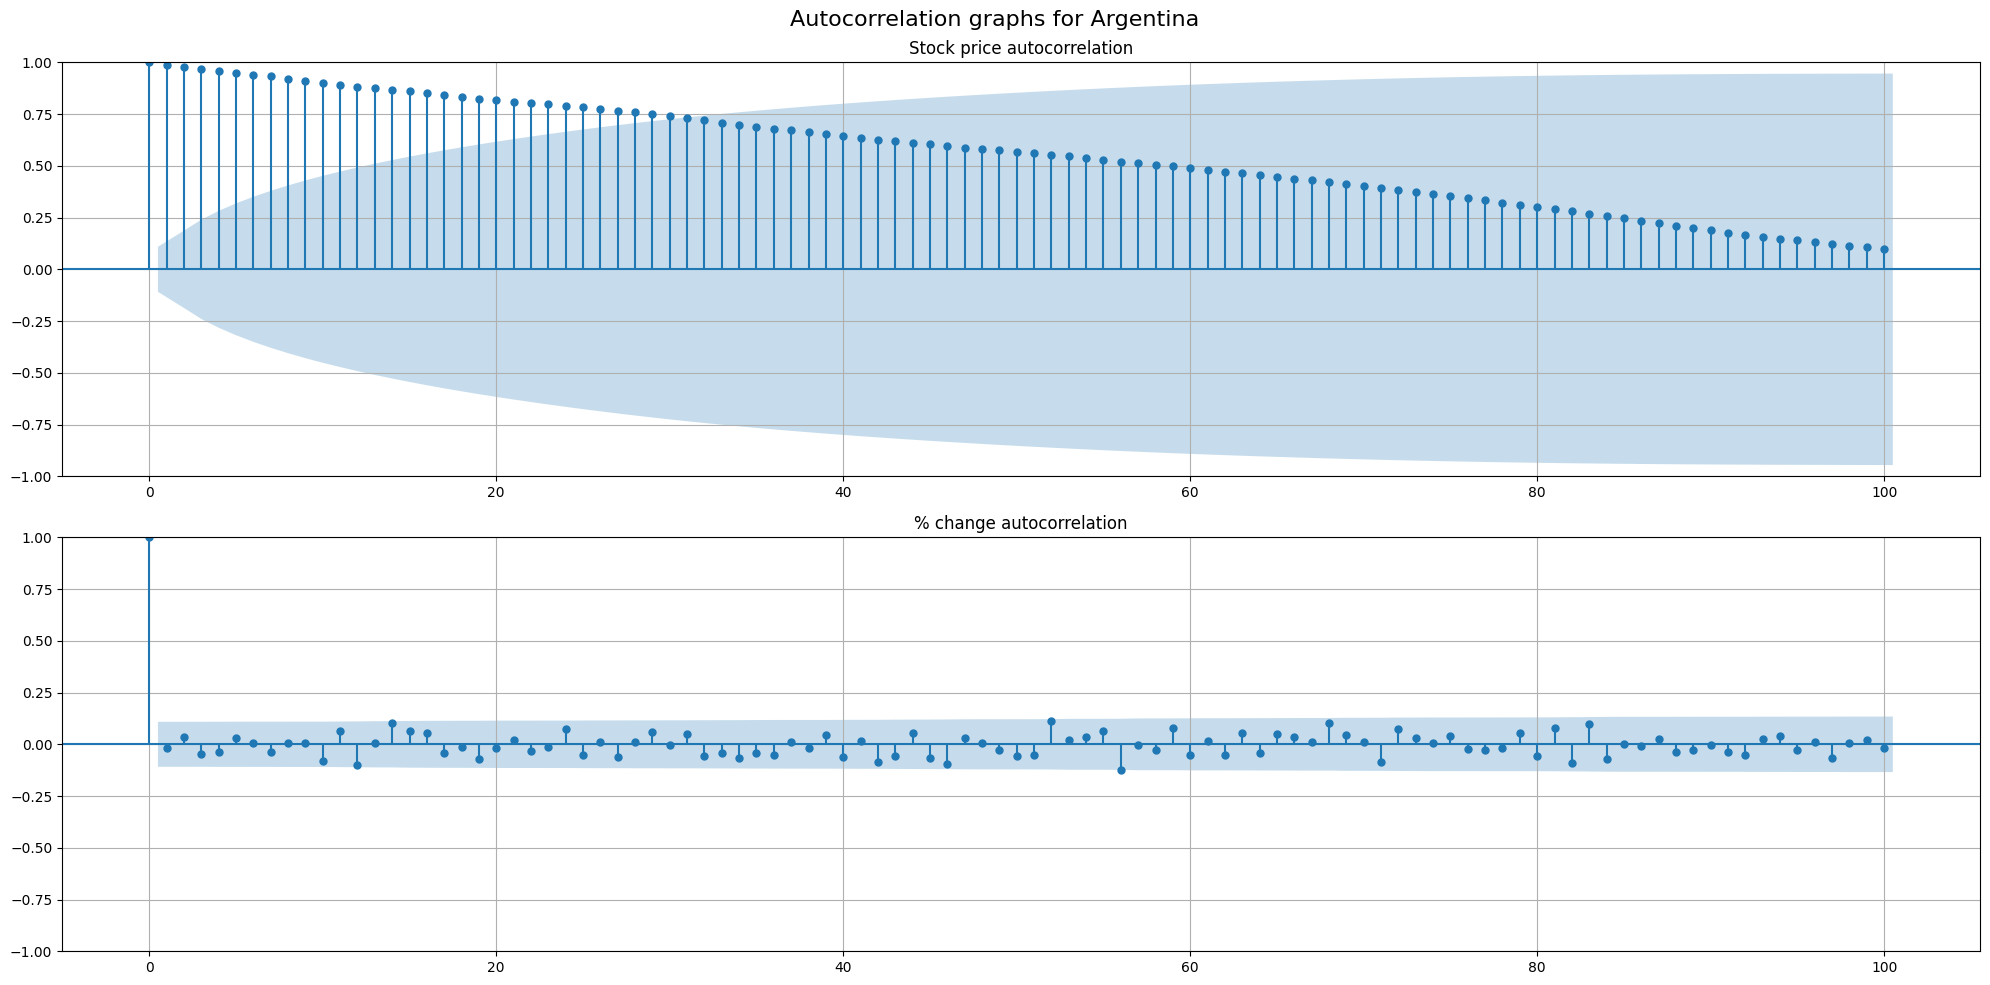

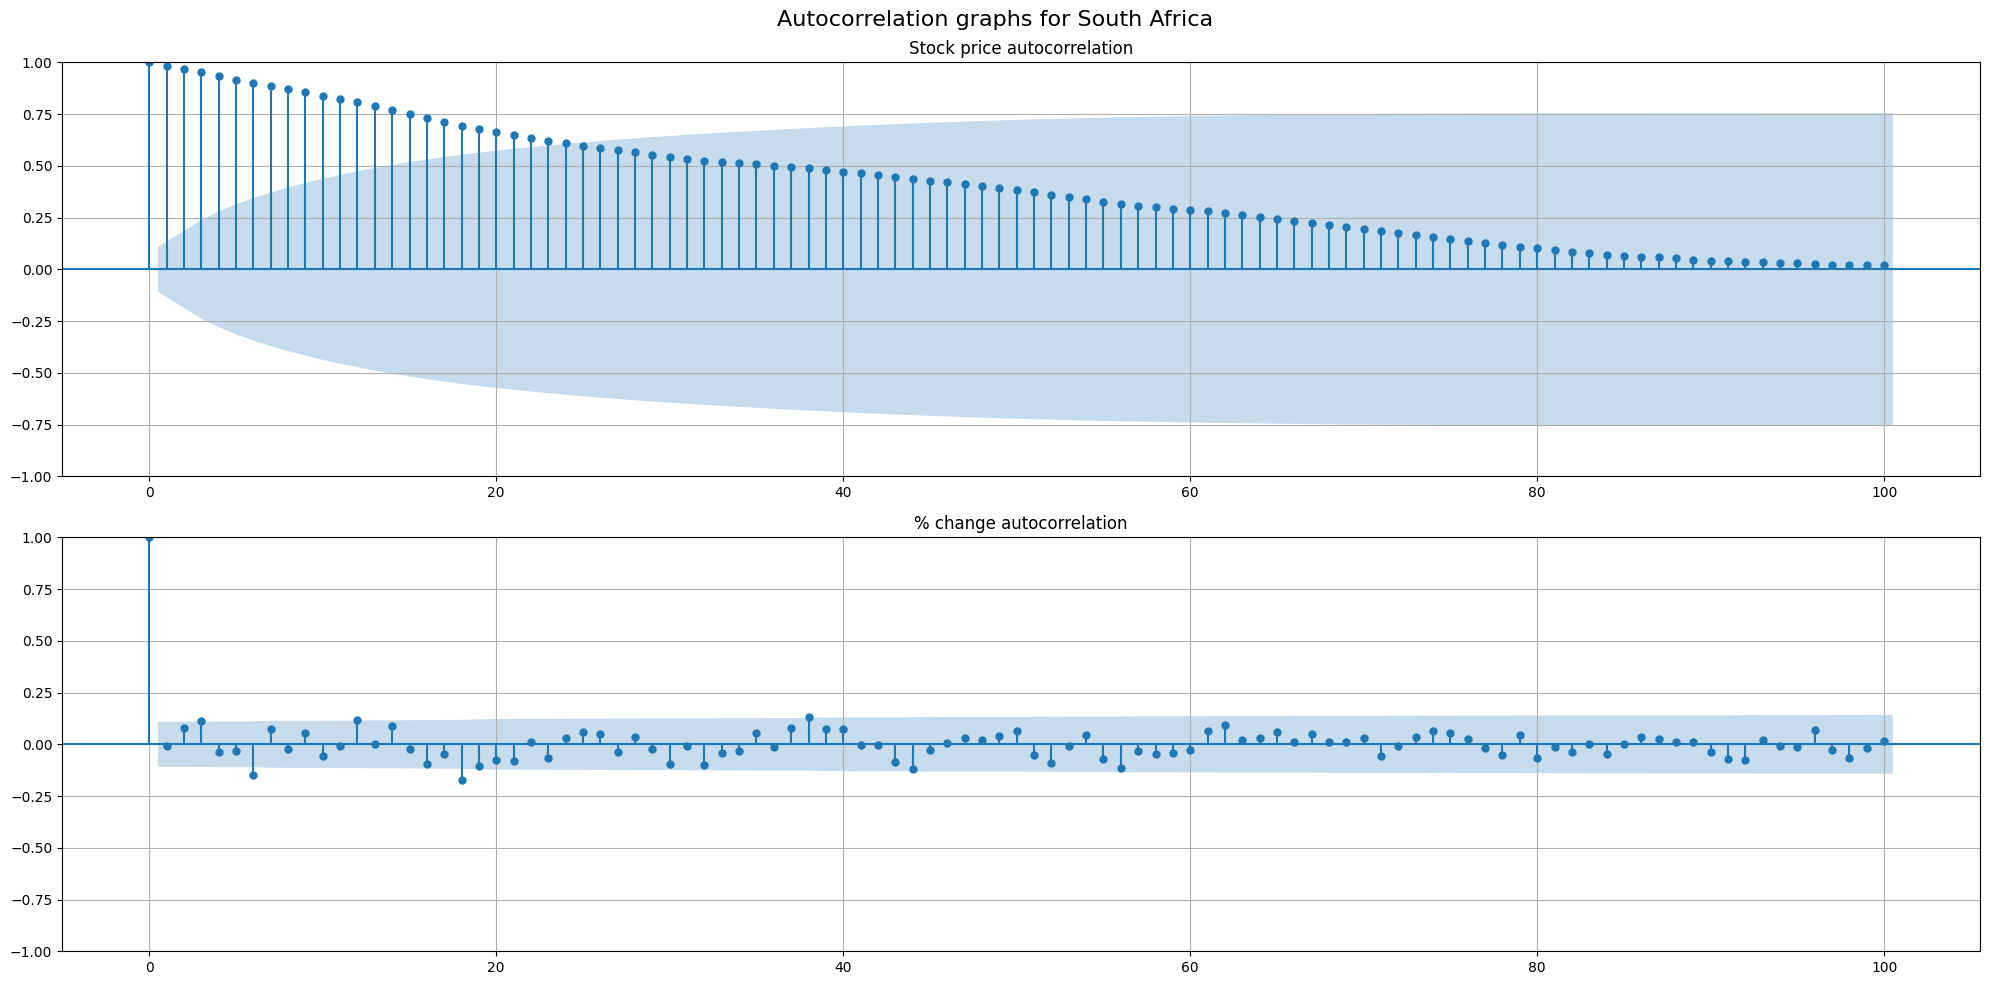

In [31]:
for key in data.keys():

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
  # Plot the price autocorrelation in subplot 1
  sm.graphics.tsa.plot_acf(data[key]['Price'], lags=100, ax=axes[0])
  axes[0].set_title('Stock price autocorrelation')
  axes[0].grid('on')

  # Plot the Change % in subplot 2
  sm.graphics.tsa.plot_acf(data[key]['Change %'], lags=100, ax=axes[1])
  axes[1].set_title('% change autocorrelation')
  axes[1].grid('on')

  # set the figure title
  fig.suptitle(f'Autocorrelation graphs for {key}', fontsize=16)

  plt.tight_layout()
  plt.show()

we observe **strong correlation** at low lags for the Price time series. This is due to the trend in the data.

On the other hand, the Change % show **low correlation** at any lags, with rare exceptions.

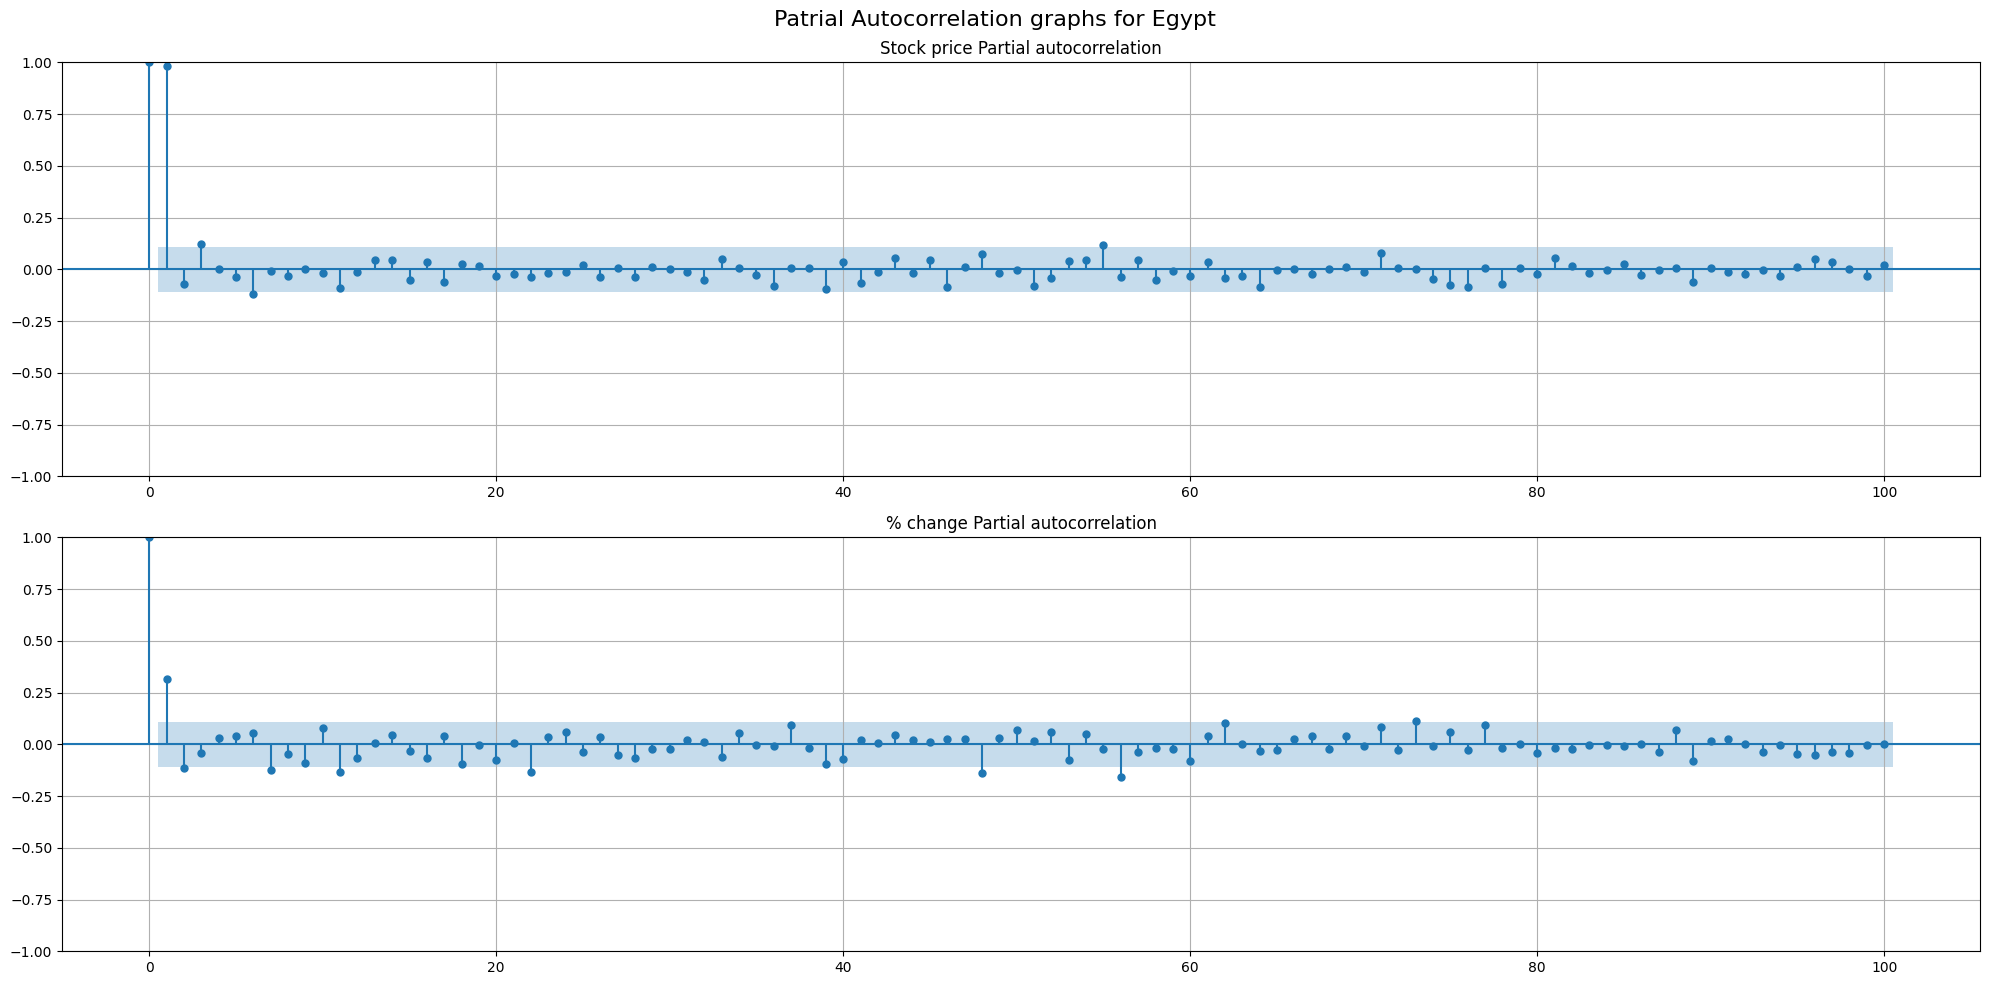

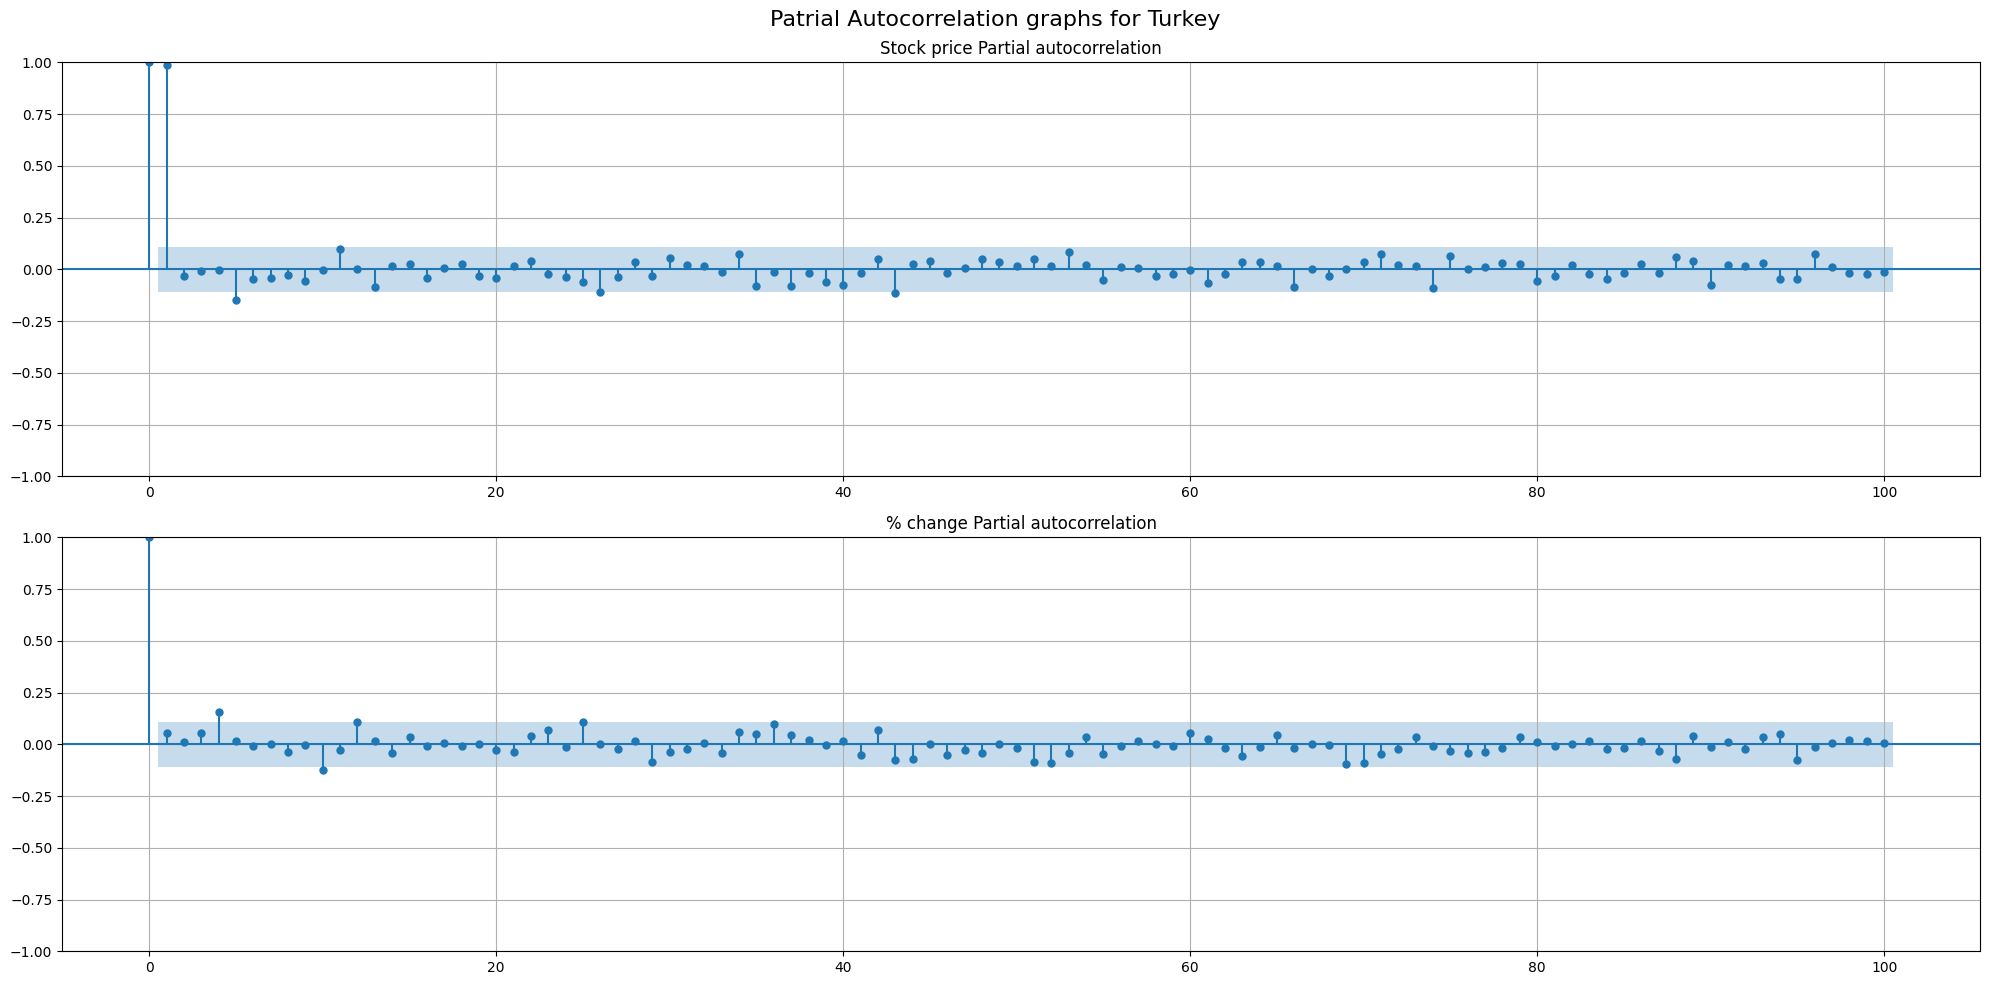

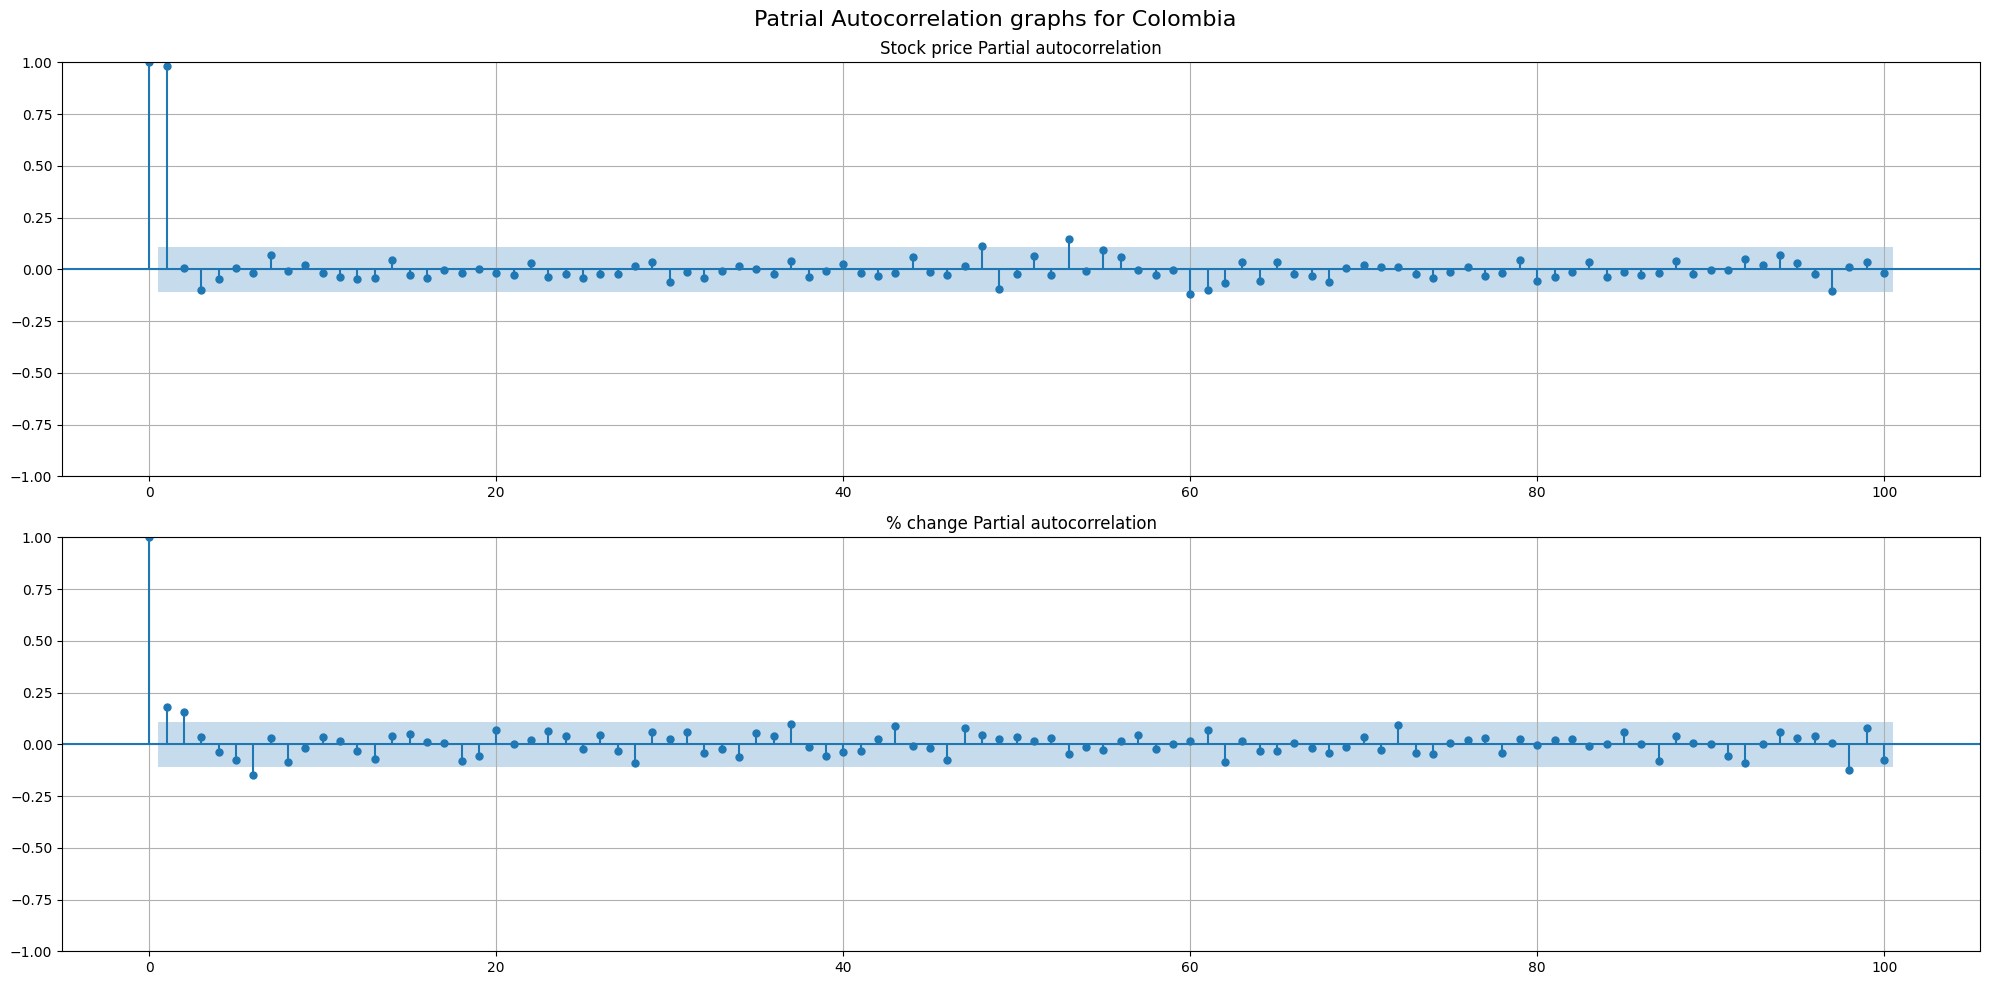

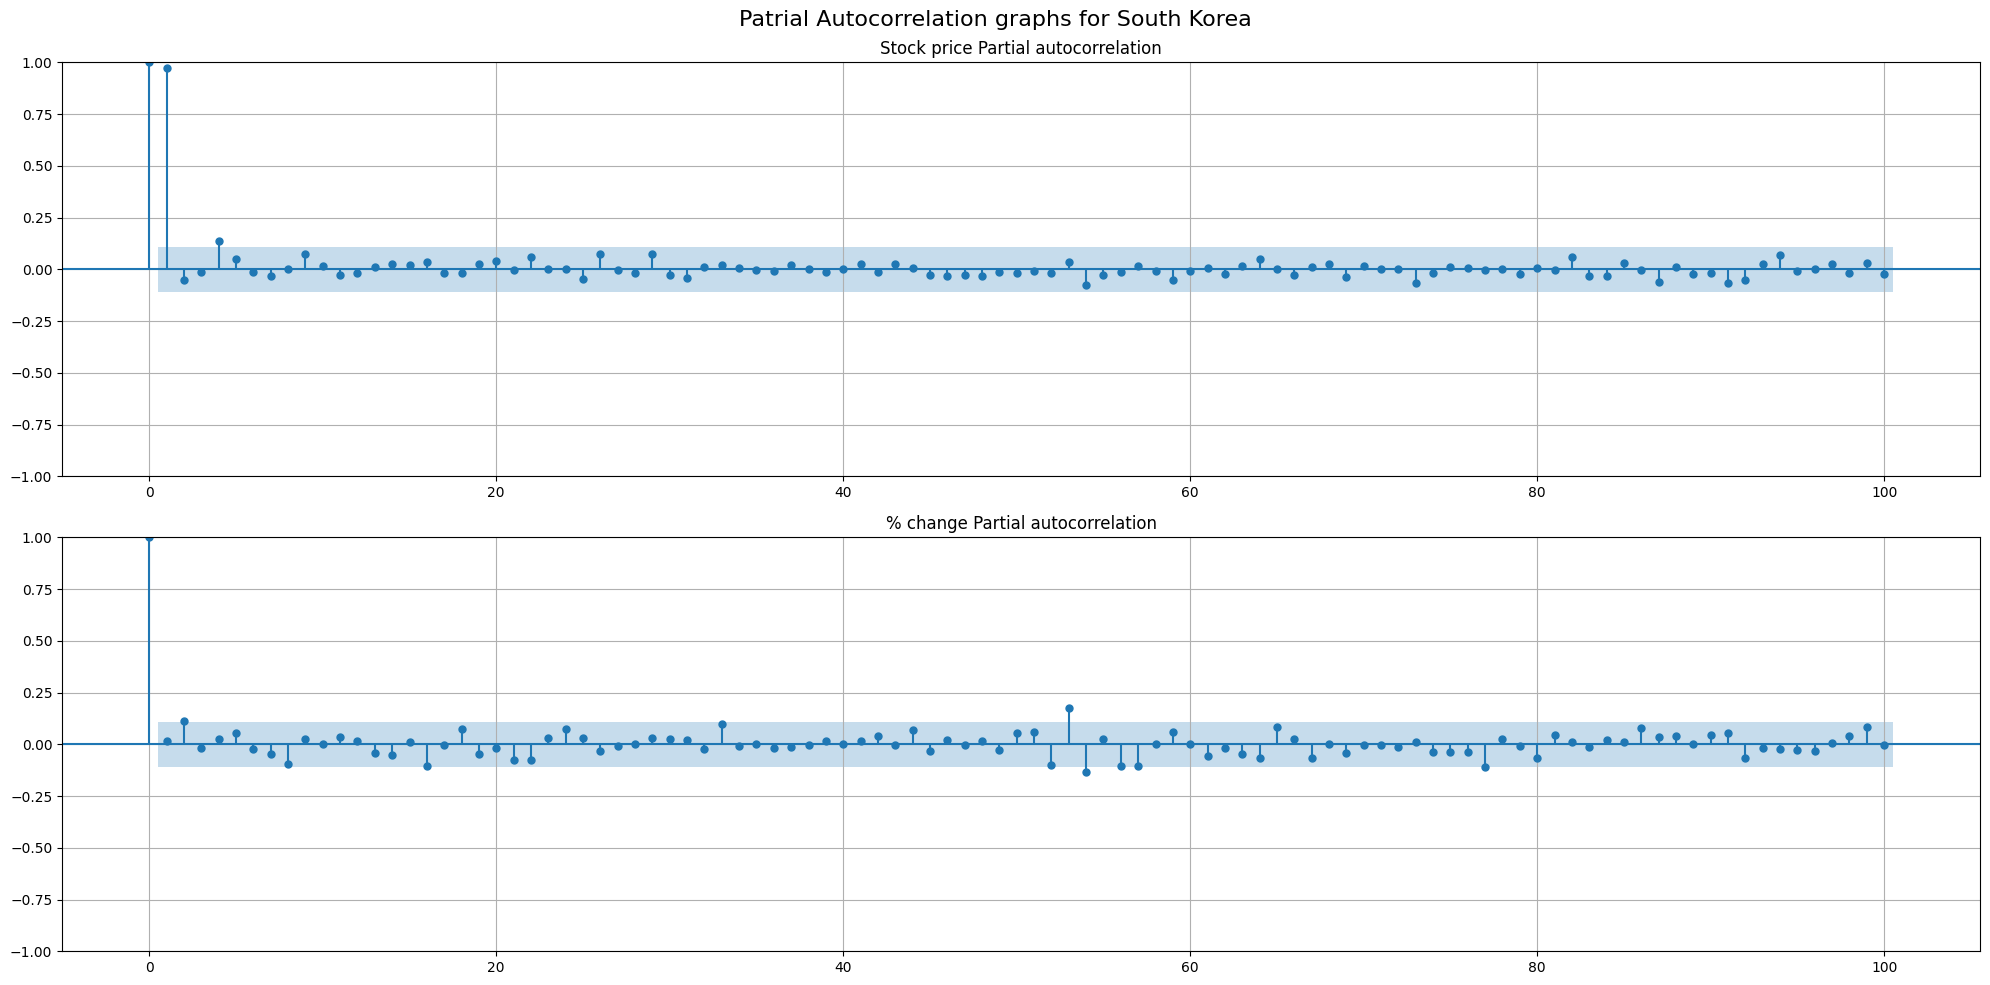

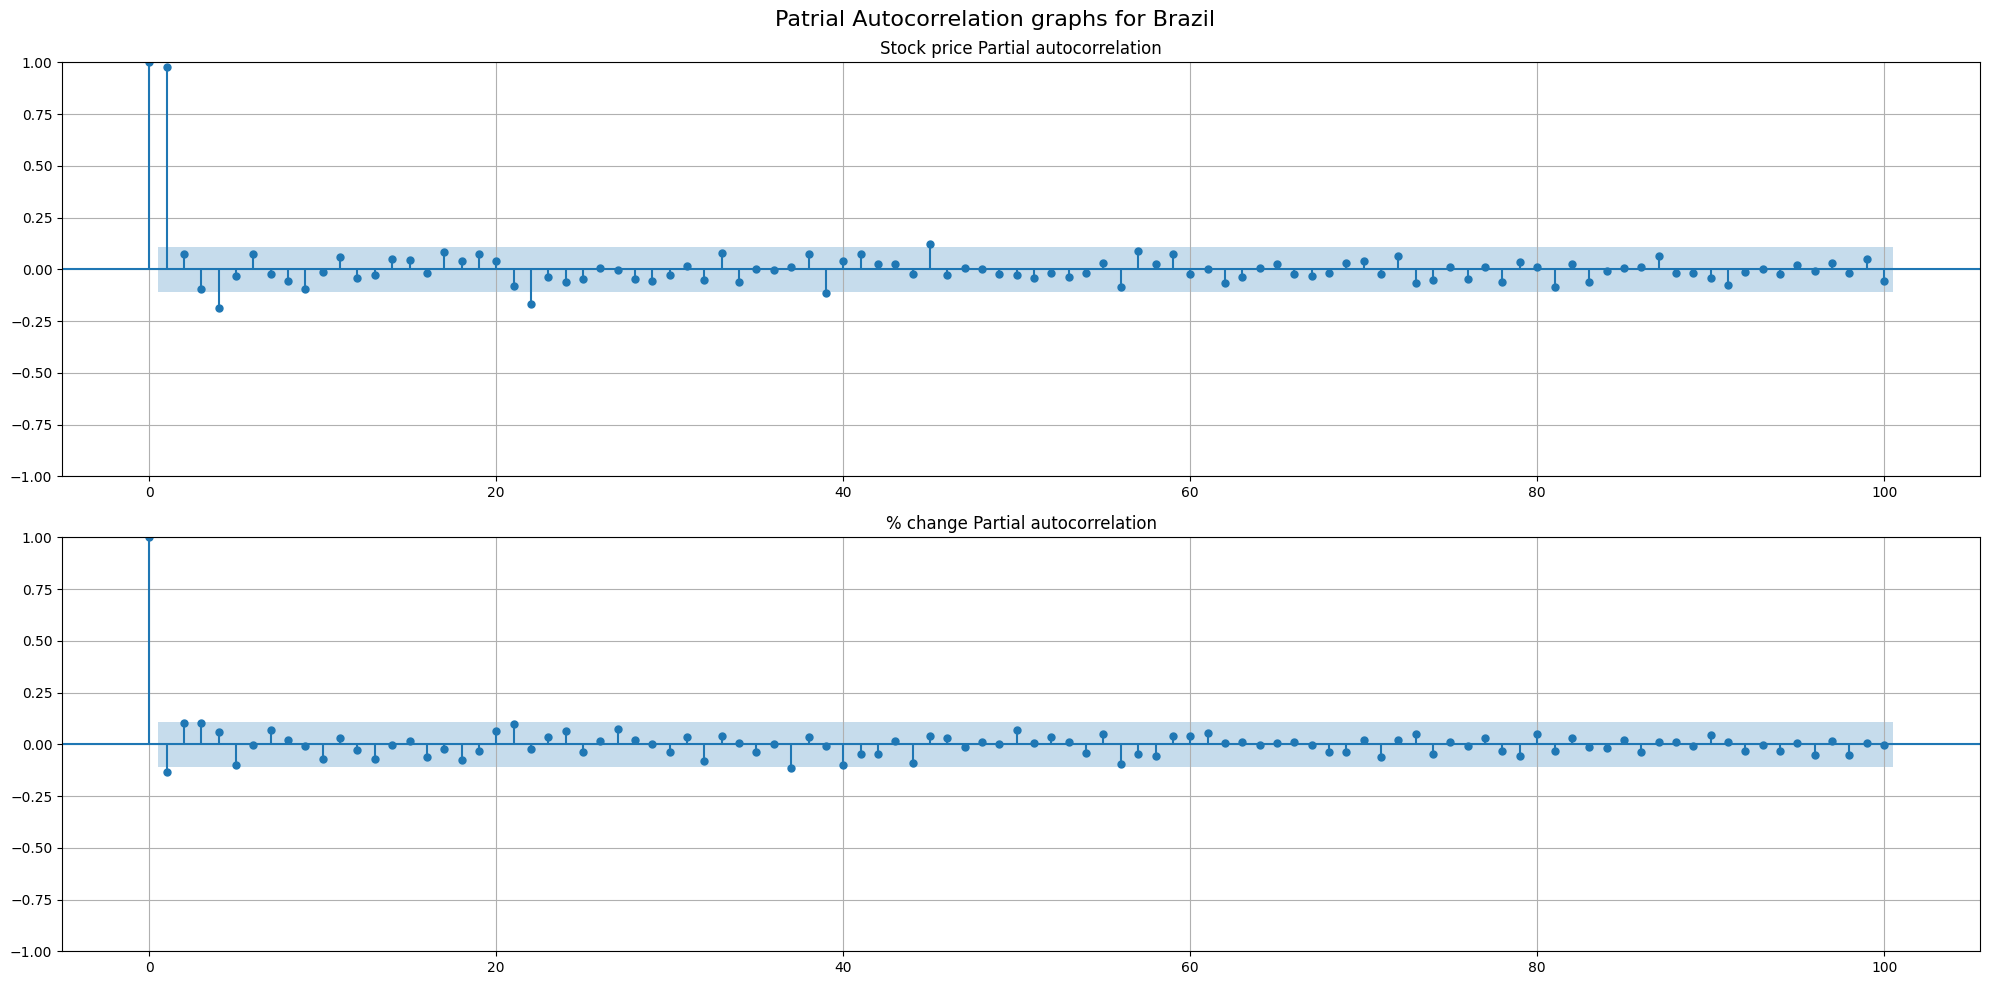

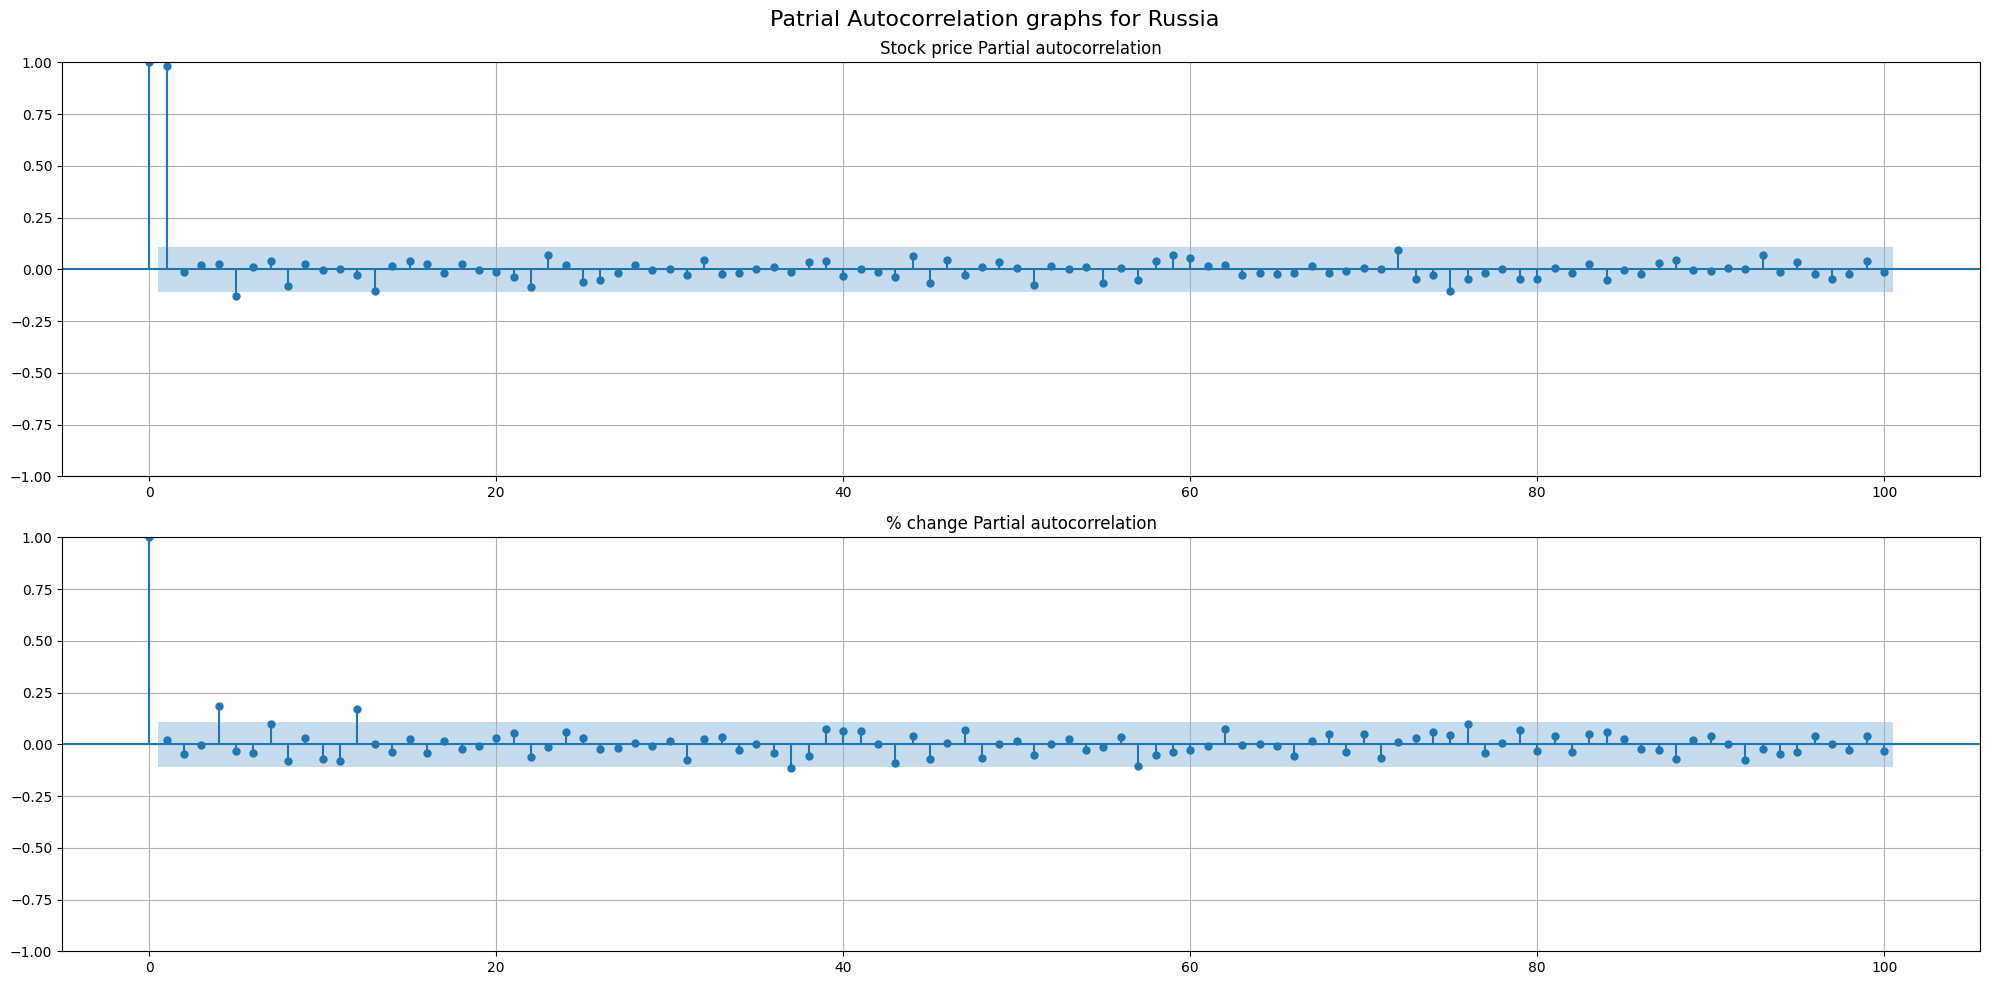

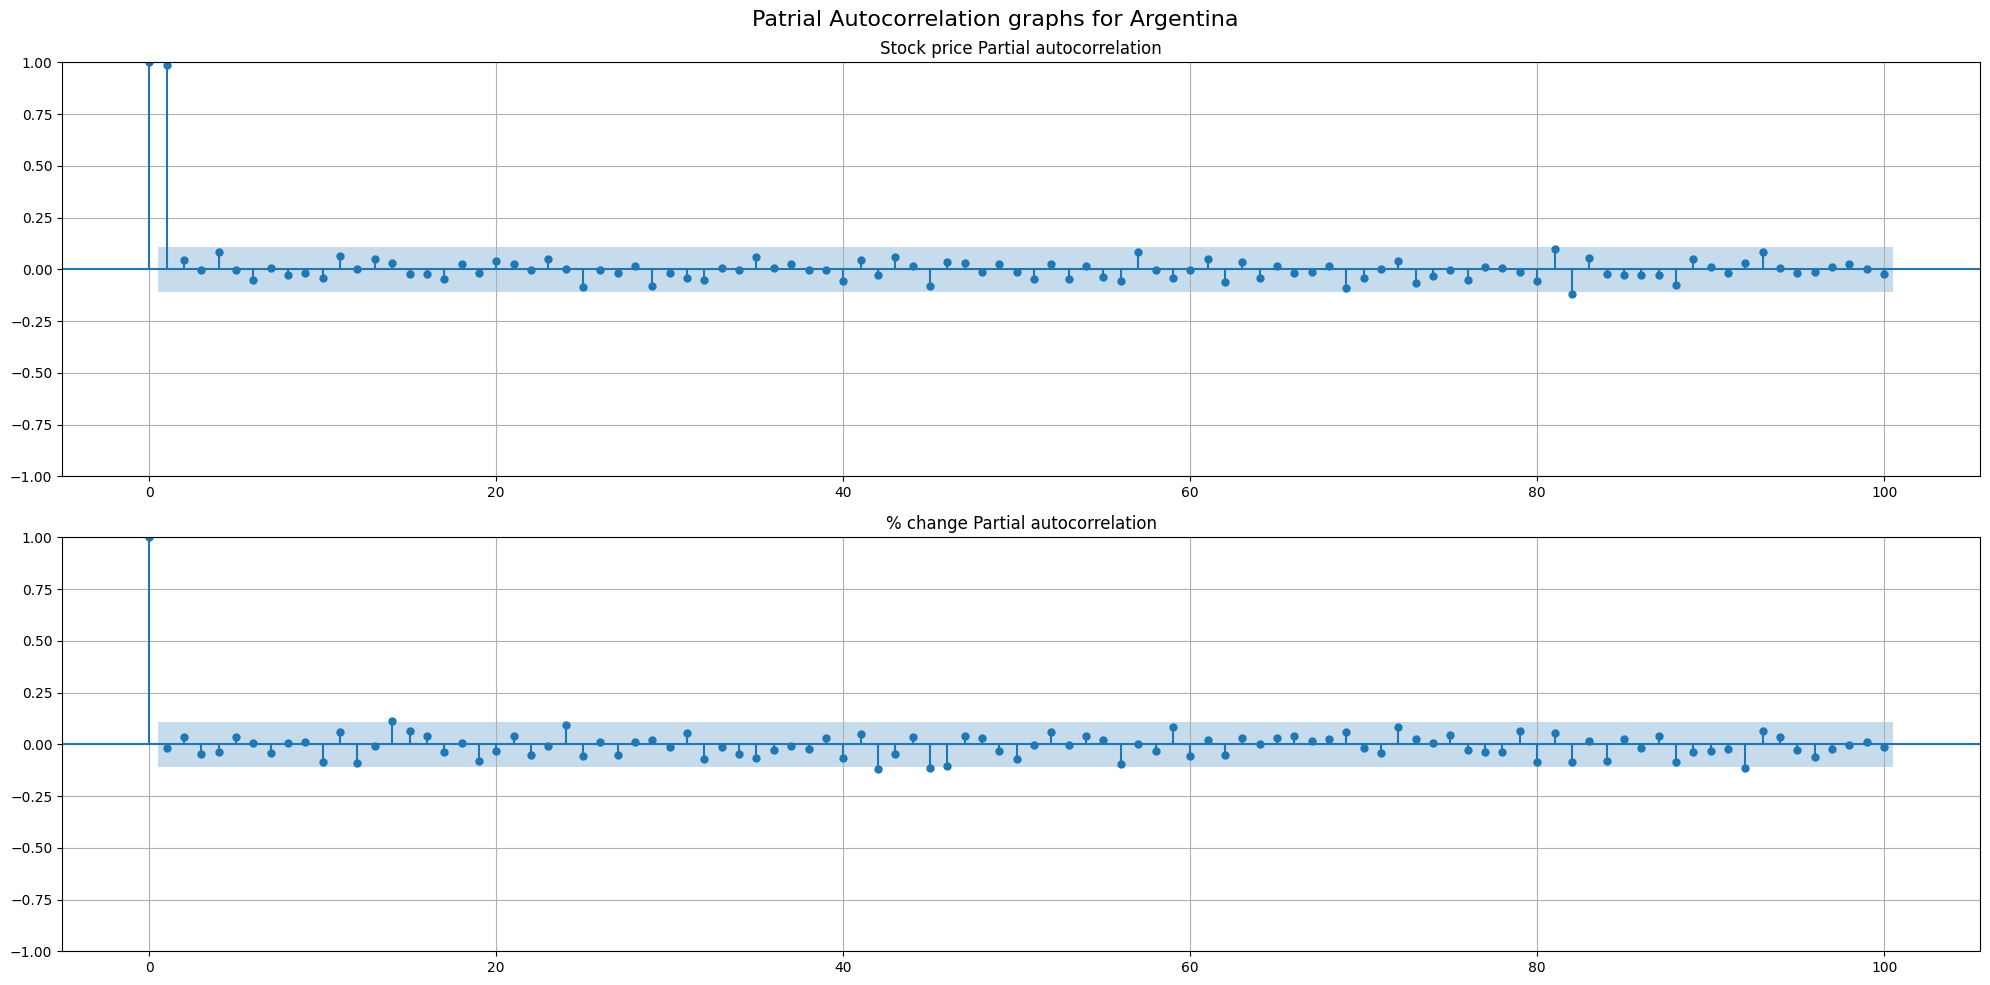

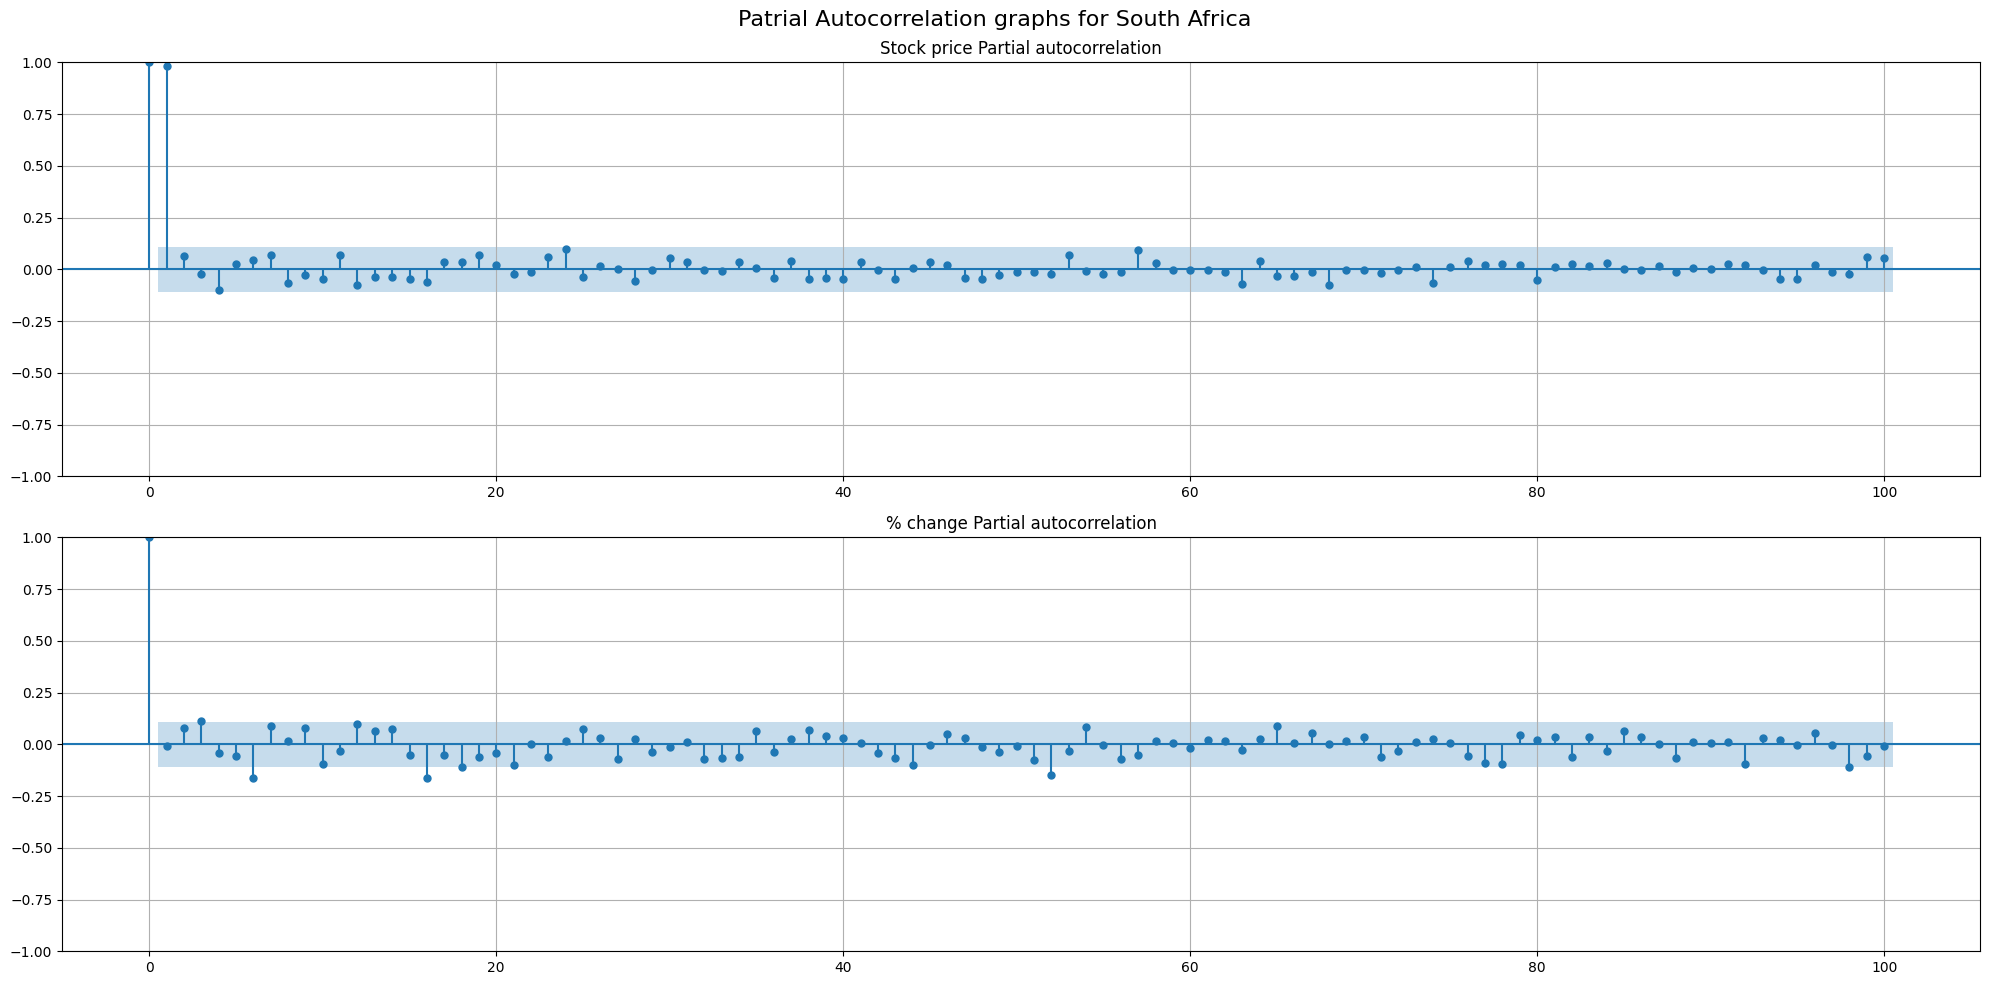

In [32]:
for key in data.keys():

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
  # Plot the price autocorrelation in subplot 1
  sm.graphics.tsa.plot_pacf(data[key]['Price'], lags=100, ax=axes[0])
  axes[0].set_title('Stock price Partial autocorrelation')
  axes[0].grid('on')

  # Plot the Change % in subplot 2
  sm.graphics.tsa.plot_pacf(data[key]['Change %'], lags=100, ax=axes[1])
  axes[1].set_title('% change Partial autocorrelation')
  axes[1].grid('on')

  # set the figure title
  fig.suptitle(f'Patrial Autocorrelation graphs for {key}', fontsize=16)

  plt.tight_layout()
  plt.show()

Every price time series show a **very strong** partial autocorrelation at lag 1, and immediately after it drops.

This is expected, given the highly unpredictable nature of the stock market: the last day price influence the current price - but all the others have little to no influence

On the other hand, the Change % time series show some relevant partial autocorrelation values at higher lags.



# Models

In [41]:
trained_models = {}
train_end = datetime(2020,12,31)

for key in data.keys():

  train_data = data[key]['Price'][:train_end]
  test_data = data[key]['Price'][train_end + timedelta(days=1):]

  model = auto_arima(train_data)
  print(f'############################################################################\n\n{key.upper()}\n')
  print(model.summary())
  print('\n\n')
  trained_models[key] = model


############################################################################

EGYPT

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  261
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 247.043
Date:                Fri, 15 Sep 2023   AIC                           -484.086
Time:                        15:36:39   BIC                           -466.283
Sample:                    01-02-2020   HQIC                          -476.929
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2748      0.108      2.540      0.011       0.063       0.487
ar.L2         -0.8075      0.093     -8.643   

We notice that all of the models computed by the autoARIMA are fairly simple:
the maximum lag considered is 3.

This was expected from the EDA

In [19]:
exp_data = change['Brazil']
exp_data = exp_data.asfreq('b')
exp_data = exp_data.fillna(method='ffill')

split the data in train and test

In [20]:
train_end = datetime(2020,12,31)

train_data = exp_data[:train_end]
test_data = exp_data[train_end + timedelta(days=1):]

Get the prediction timeframe (= test timeframe)

In [22]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# ARMA(1,1)

Fit the model

In [23]:
model = ARIMA(train_data, order=(1,0,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Change %   No. Observations:                  261
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -712.246
Date:                Thu, 14 Sep 2023   AIC                           1432.492
Time:                        15:09:14   BIC                           1446.750
Sample:                    01-02-2020   HQIC                          1438.223
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0407      0.226     -0.180      0.857      -0.483       0.402
ar.L1         -0.5541      0.161     -3.436      0.001      -0.870      -0.238
ma.L1          0.4256      0.174      2.442      0.0

As expected, the P value of both coefficients is lower than 0.5, so both are significat.

Compute the predictions

In [24]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

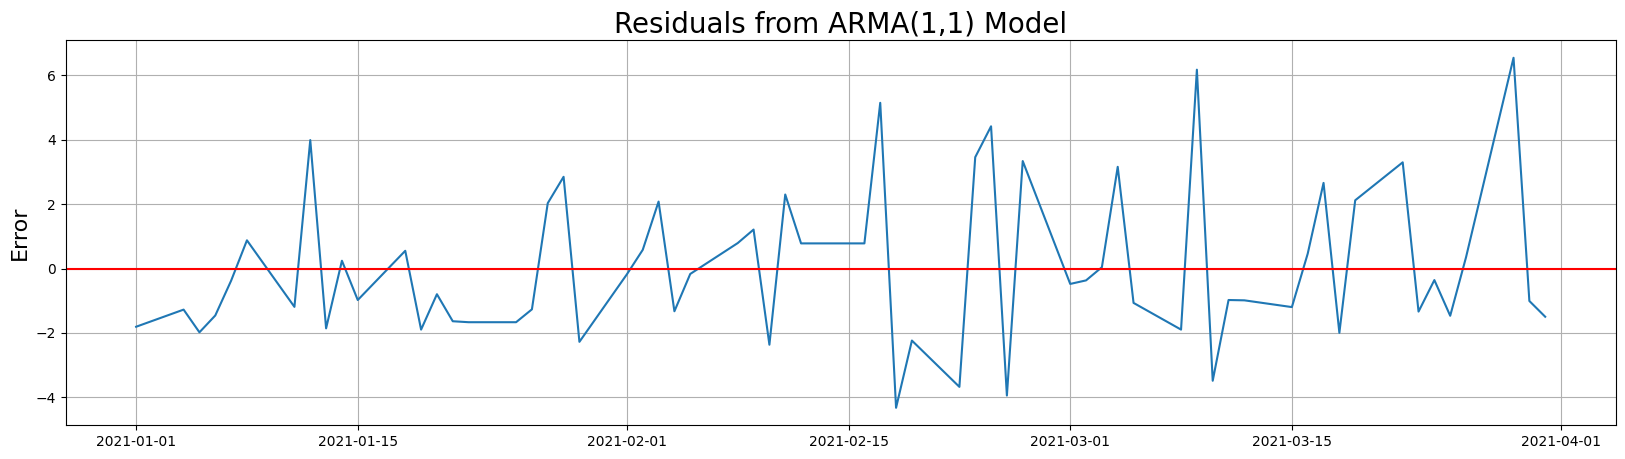

In [26]:
plt.figure(figsize=(20,5))
plt.plot(residuals)
plt.title('Residuals from ARMA(1,1) Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r')
plt.grid('on')
plt.show()

looking at the residuals, we are kinda close to the true value, but the error oscillates in time

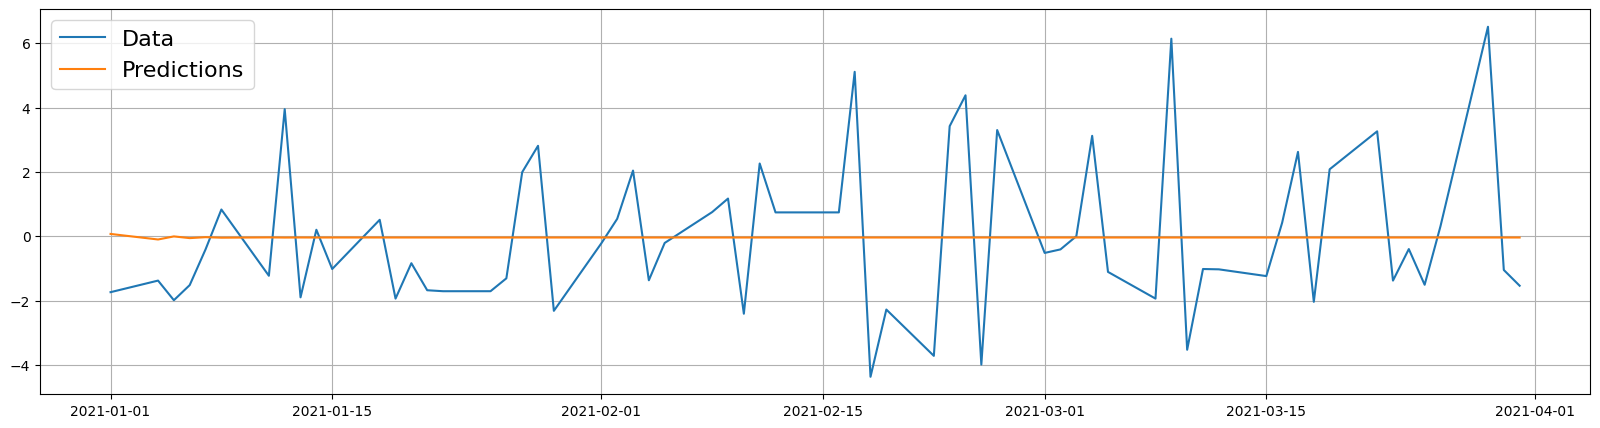

In [27]:
plt.figure(figsize=(20,5))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.grid('on')
plt.show()

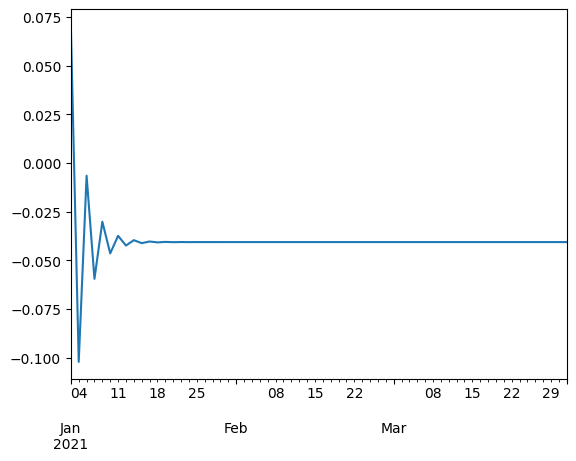

In [28]:
predictions.plot()
plt.show()

the predictions are settling (quite fast) to a constant value.

In [39]:
print('Mean Absolute Error:', round(np.mean(abs(residuals)), 4))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(residuals**2)), 4))

Mean Absolute Error: 1.8689
Root Mean Squared Error: 2.355


The mean absolute error is relatively high: 1.86%

# ARMA(3,2) & ARMA(2,2)

Fit the model

In [43]:
model = ARIMA(train_data, order=(3,0,2))
model_fit = model.fit()

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:               Change %   No. Observations:                  261
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -706.316
Date:                Thu, 14 Sep 2023   AIC                           1426.631
Time:                        15:16:53   BIC                           1451.583
Sample:                    01-02-2020   HQIC                          1436.661
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0448      0.252     -0.178      0.859      -0.538       0.448
ar.L1          0.1441      0.072      2.014      0.044       0.004       0.284
ar.L2         -0.6468      0.134     -4.824      0.0

We notice that the third lag in the AR part is not statistically relevant (P value above 0.5).
Hence, let's straight away reduce the model to an ARMA(2,2) model

In [44]:
model = ARIMA(train_data, order=(2,0,2))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Change %   No. Observations:                  261
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -706.324
Date:                Thu, 14 Sep 2023   AIC                           1424.648
Time:                        15:18:11   BIC                           1446.035
Sample:                    01-02-2020   HQIC                          1433.245
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0455      0.250     -0.182      0.856      -0.536       0.445
ar.L1          0.1429      0.069      2.070      0.038       0.008       0.278
ar.L2         -0.6560      0.088     -7.464      0.0

In [45]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

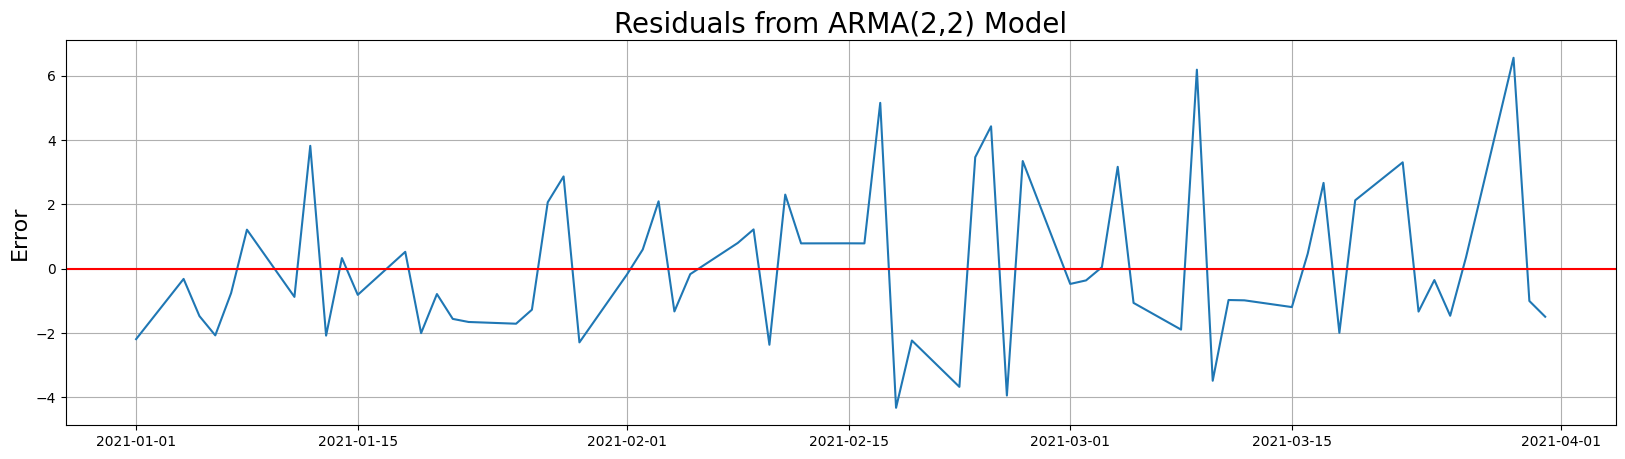

In [46]:
plt.figure(figsize=(20,5))
plt.plot(residuals)
plt.title('Residuals from ARMA(2,2) Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r')
plt.grid('on')
plt.show()

There is not a big difference between these residuals and the one obtained with the simpler model

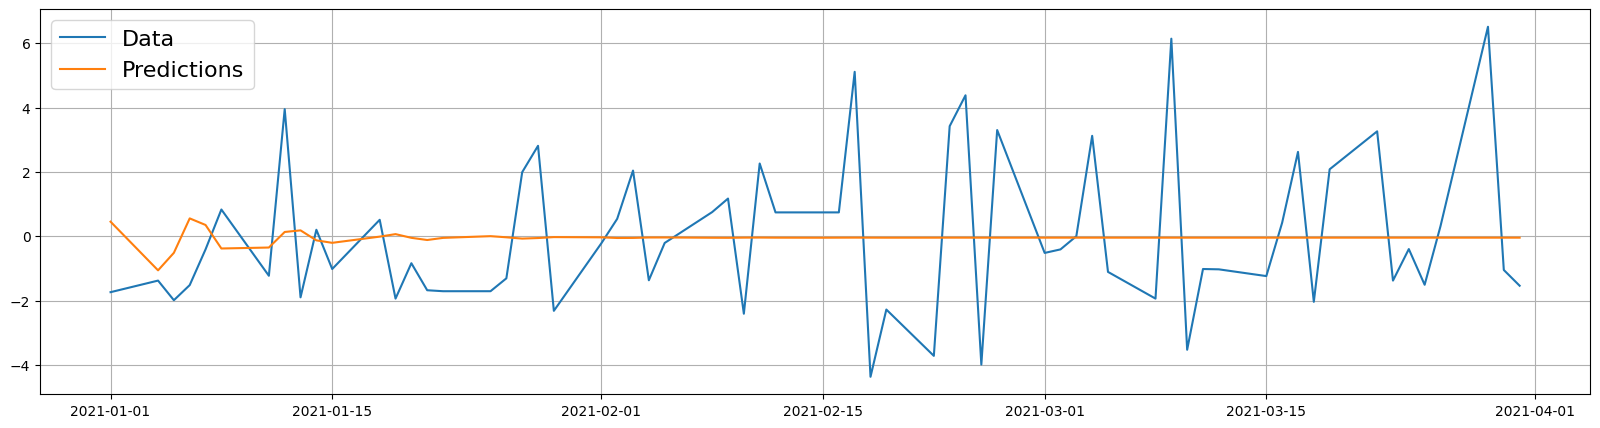

In [47]:
plt.figure(figsize=(20,5))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.grid('on')
plt.show()

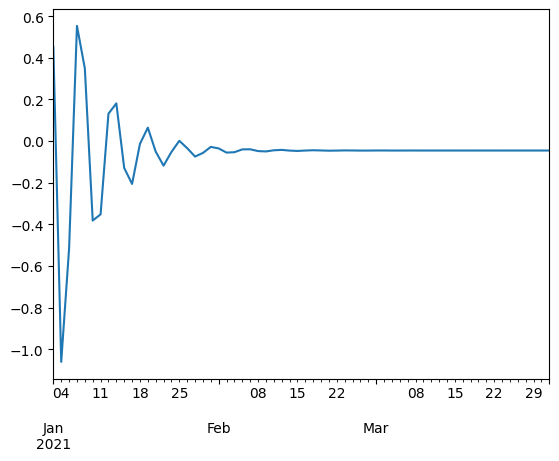

In [48]:
predictions.plot()
plt.show()

Actually, we noticed that at the beginning of the prediction horizon, the estimated values are closer to the real ones

In [49]:
print('Mean Absolute Error:', round(np.mean(abs(residuals)), 4))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(residuals**2)), 4))

Mean Absolute Error: 1.8693
Root Mean Squared Error: 2.3578


The evaluation metrics, as expected, show the same performance level as the previous model

# Rolling Forecast Origin

We need to predict the stock prices on a **daily**, **weekly** and **monthly** basis.



In [50]:
# Define forecasting horizon (number of days to forecast)
forecast_horizon = 1

# Initialize an empty DataFrame to store forecast results
forecast_results = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])

# Perform rolling forecasts
for idx, end_date in enumerate(test_data.index[forecast_horizon-1:]):

  start_date = test_data.index[idx]

  # Select the training data up to the start_date
  curr_train_data = exp_data[:start_date - timedelta(days=1)]
  curr_test_data = exp_data[start_date : end_date]

  # train the model
  model = ARIMA(curr_train_data, order=(2,0,2))
  model_fit = model.fit()

  # make the predictions
  predictions = model_fit.predict(start=start_date, end=end_date)

  # Concat the results to the dataframe
  curr_results = pd.DataFrame({
      'Date': curr_test_data.index,
      'Actual': curr_test_data.values,
      'Forecast': np.round(predictions.values, 2)
  })
  forecast_results = pd.concat((forecast_results, curr_results), ignore_index=True)


In [51]:
import plotly.express as px

fig = px.line(forecast_results, x='Date', y=['Actual', 'Forecast'])
fig.show()

In [53]:
residuals = forecast_results['Actual'] - forecast_results['Forecast']

print('Mean Absolute Error:', round(np.mean(abs(residuals)), 4))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(residuals**2)), 4))

Mean Absolute Error: 1.9331
Root Mean Squared Error: 2.4554


using a rolling origin approach we improve the quality of the predictions, but not that much.

The problem here is the **model**: we are not using the most appropriate one